In [15]:
import pandas as pd
import joblib
# Load your train and test datasets
test_df = pd.read_excel("./data/test_dataframes.xlsx")

# Ensure datetime is correctly set
if "datetime" in test_df.columns:
    test_df["datetime"] = pd.to_datetime(test_df["datetime"])
    test_df.set_index("datetime", inplace=True)

# -------------------------
# Feature Engineering - Must be SAME for both train and test
# -------------------------

# Lags
for lag in [1, 7, 14, 21, 28]:
    test_df[f"lag_{lag}"] = test_df["DEMAND"].shift(lag)

# Rolling means and std
for window in [3, 7, 14]:
    test_df[f"rolling_mean_{window}"] = test_df["DEMAND"].rolling(window=window).mean()

test_df["rolling_std_7"] = test_df["DEMAND"].rolling(window=7).std()

# Time-based features
for df_ in  [test_df]:
    df_["hour"] = df_.index.hour
    df_["dayofweek"] = df_.index.dayofweek
    df_["month"] = df_.index.month
    df_["is_weekend"] = df_.index.dayofweek.isin([5, 6]).astype(int)

# -------------------------
# Drop NaNs generated by rolling/lags
# -------------------------
test_df.dropna(inplace=True)

# -------------------------
# Create X_train, y_train, and X_test
# -------------------------
TARGET = "DEMAND"

features = [col for col in test_df.columns if col != TARGET]

X_test = test_df[features]  # Same features as training
y_test = test_df['DEMAND']

# Confirm shape
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")




X_test shape: (140, 23)
y_test shape: (140,)


In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [32]:
# XGB
# Load the model from the folder
XGB_model = joblib.load("./model_weights/tuned_xgb_model.pkl")
# RF
RF_model = joblib.load("./model_weights/tuned_random_forest_model.pkl")
# DT
DT_model = joblib.load("./model_weights/tuned_decision_tree_model.pkl")
# GB
GB_model = joblib.load("./model_weights/tuned_gradient_boosting_model.pkl")
#Arima
AR_model = joblib.load("./model_weights/arima_model.pkl")

#AR_MLP
arima, mlp = joblib.load("./model_weights/arima_mlp_hybrid_arima_part.pkl"), joblib.load("./model_weights/arima_mlp_hybrid_mlp_part.pkl")
arima_pred = arima.forecast(steps=len(X_test))
mlp_residual = mlp.predict(X_test)
final_pred = arima_pred + mlp_residual

#SVR
SVR_model = joblib.load("./model_weights/svr_rbf_model.pkl")

#RF_XG_AR
rf, xgb_model, arima = joblib.load("./model_weights/hybrid2_rf_model.pkl"),joblib.load("./model_weights/hybrid2_xgb_model.pkl"), joblib.load("./model_weights/hybrid2_arima_model.pkl")
rf_pred = rf.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
arima_pred = arima.forecast(steps=len(X_test))
final_pred = (rf_pred + xgb_pred + arima_pred) / 3


# Make predictions on the test data using the best model

# y_pred_dt = CNN_LSTM_model.predict(X_test_lstm)

# # Evaluate the best model - Calculate MAE and RMSE
# mae_dt = mean_absolute_error(y_test, y_pred_dt)
# rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

print(f"Decision Tree (Tuned) - Mean Absolute Error (MAE): {mae_dt:.2f}")
print(f"Decision Tree (Tuned) - Root Mean Squared Error (RMSE): {rmse_dt:.2f}")

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pred

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/stepWARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x30f8e20c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
CNN-LSTM - Mean Absolute Error (MAE): 47.58
CNN-LSTM - Root Mean Squared Error (RMSE): 63.81
Decision Tree (Tuned) - Mean Absolute Error (MAE): 1266.43
Decision Tree (Tuned) - Root Mean Squared Error (RMSE): 1281.79


# DL models

In [43]:
# CNN_LSTM
# Prepare data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

time_step = 60  # Number of previous time steps to use for prediction
X_test_lstm, y_test_lstm = create_dataset(y_test_scaled, time_step)

# Reshape data for LSTM input
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)


CNN_LSTM_model = load_model("./model_weights/cnn_lstm_model.h5")
# Make predictions
predicted_demand_cnn_lstm = CNN_LSTM_model.predict(X_test_lstm)

# Inverse transform predictions and actual values
predicted_demand_cnn_lstm = scaler.inverse_transform(predicted_demand_cnn_lstm)
y_test_actual_cnn_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluate the model (MAE, RMSE)
mae_cnn_lstm = mean_absolute_error(y_test_actual_cnn_lstm, predicted_demand_cnn_lstm)
rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test_actual_cnn_lstm, predicted_demand_cnn_lstm))

print(f"CNN-LSTM - Mean Absolute Error (MAE): {mae_cnn_lstm:.2f}")
print(f"CNN-LSTM - Root Mean Squared Error (RMSE): {rmse_cnn_lstm:.2f}")


# GRU
GRU_model = load_model("./model_weights/gru_model.h5")
# Make predictions
predicted_demand_cnn_lstm = GRU_model.predict(X_test_lstm)

# Inverse transform predictions and actual values
predicted_demand_cnn_lstm = scaler.inverse_transform(predicted_demand_cnn_lstm)
y_test_actual_cnn_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluate the model (MAE, RMSE)
mae_cnn_lstm = mean_absolute_error(y_test_actual_cnn_lstm, predicted_demand_cnn_lstm)
rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test_actual_cnn_lstm, predicted_demand_cnn_lstm))

print(f"GRU - Mean Absolute Error (MAE): {mae_cnn_lstm:.2f}")
print(f"GRU - Root Mean Squared Error (RMSE): {rmse_cnn_lstm:.2f}")

# LSTM


LSTM_model = load_model("./model_weights/lstm_model.h5")
# Make predictions
predicted_demand_cnn_lstm = LSTM_model.predict(X_test_lstm)

# Inverse transform predictions and actual values
predicted_demand_cnn_lstm = scaler.inverse_transform(predicted_demand_cnn_lstm)
y_test_actual_cnn_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluate the model (MAE, RMSE)
mae_cnn_lstm = mean_absolute_error(y_test_actual_cnn_lstm, predicted_demand_cnn_lstm)
rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test_actual_cnn_lstm, predicted_demand_cnn_lstm))

print(f"LSTM - Mean Absolute Error (MAE): {mae_cnn_lstm:.2f}")
print(f"LSTM - Root Mean Squared Error (RMSE): {rmse_cnn_lstm:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step


CNN-LSTM - Mean Absolute Error (MAE): 47.58
CNN-LSTM - Root Mean Squared Error (RMSE): 63.81
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


GRU - Mean Absolute Error (MAE): 36.90
GRU - Root Mean Squared Error (RMSE): 45.21
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
LSTM - Mean Absolute Error (MAE): 52.10
LSTM - Root Mean Squared Error (RMSE): 61.35


TypeError: Could not locate class 'SimplifiedTFT'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'SimplifiedTFT', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'SimplifiedTFT', 'build_config': {'input_shape': [None, 60, 1]}, 'compile_config': {'optimizer': 'adam', 'loss': 'mean_squared_error', 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}

Loading test data...
Preparing X_test and y_test...
Evaluating CNN-LSTM...


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Evaluating GRU...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Evaluating LSTM...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
Evaluating XGBoost...
Evaluating Random Forest...
Evaluating Decision Tree...
Evaluating Gradient Boosting...
Evaluating ARIMA...


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Evaluating ARIMA-MLP Hybrid...


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Evaluating SVR...
Evaluating RF-XGB-ARIMA Hybrid...


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



Final Evaluation Metrics:
CNN-LSTM        | MAE: 47.58 | RMSE: 63.81 | MAPE: 4.10%
GRU             | MAE: 36.90 | RMSE: 45.21 | MAPE: 3.07%
LSTM            | MAE: 52.10 | RMSE: 61.35 | MAPE: 4.47%
XGB             | MAE: 16.09 | RMSE: 20.41 | MAPE: 1.30%
RF              | MAE: 0.64 | RMSE: 0.96 | MAPE: 0.05%
DT              | MAE: 0.31 | RMSE: 1.26 | MAPE: 0.02%
GB              | MAE: 14.52 | RMSE: 18.86 | MAPE: 1.18%
ARIMA           | MAE: 229.94 | RMSE: 295.71 | MAPE: 16.41%
ARIMA_MLP       | MAE: 230.62 | RMSE: 299.95 | MAPE: 16.45%
SVR             | MAE: 22.34 | RMSE: 29.57 | MAPE: 1.79%
RF_XGB_AR       | MAE: 78.15 | RMSE: 100.05 | MAPE: 5.59%


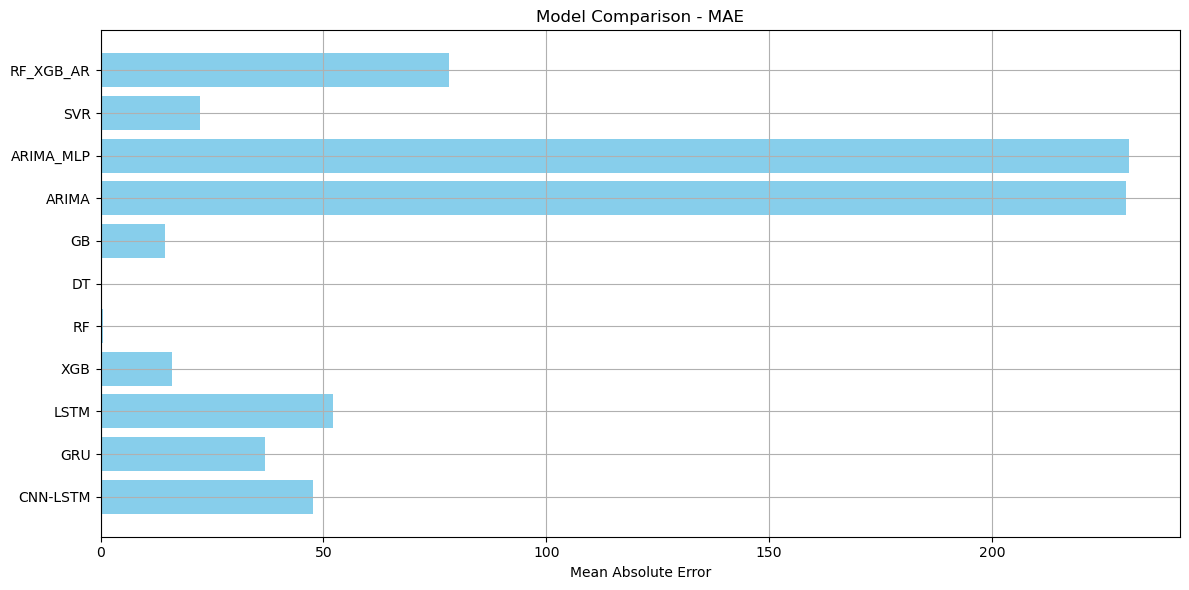

In [44]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load test data
print("Loading test data...")
test_df = pd.read_excel("./data/test_dataframes.xlsx")
test_df["datetime"] = pd.to_datetime(test_df["datetime"])
test_df.set_index("datetime", inplace=True)

# Feature Engineering
for lag in [1, 7, 14, 21, 28]:
    test_df[f"lag_{lag}"] = test_df["DEMAND"].shift(lag)
for window in [3, 7, 14]:
    test_df[f"rolling_mean_{window}"] = test_df["DEMAND"].rolling(window=window).mean()
test_df["rolling_std_7"] = test_df["DEMAND"].rolling(window=7).std()
test_df["hour"] = test_df.index.hour
test_df["dayofweek"] = test_df.index.dayofweek
test_df["month"] = test_df.index.month
test_df["is_weekend"] = test_df.index.dayofweek.isin([5, 6]).astype(int)

# Drop NA and extract X_test/y_test
print("Preparing X_test and y_test...")
test_df.dropna(inplace=True)
features = [col for col in test_df.columns if col != "DEMAND"]
X_test = test_df[features]
y_test = test_df['DEMAND']

results = {}

def evaluate(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    results[model_name] = (mae, rmse, mape)

# CNN-LSTM
print("Evaluating CNN-LSTM...")
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_dataset(y_test_scaled)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

cnn_lstm_model = load_model("./model_weights/cnn_lstm_model.h5")
pred = scaler.inverse_transform(cnn_lstm_model.predict(X_lstm))
y_actual = scaler.inverse_transform(y_lstm.reshape(-1, 1))
evaluate("CNN-LSTM", y_actual, pred)

# GRU
print("Evaluating GRU...")
gru_model = load_model("./model_weights/gru_model.h5")
pred = scaler.inverse_transform(gru_model.predict(X_lstm))
evaluate("GRU", y_actual, pred)

# LSTM
print("Evaluating LSTM...")
lstm_model = load_model("./model_weights/lstm_model.h5")
pred = scaler.inverse_transform(lstm_model.predict(X_lstm))
evaluate("LSTM", y_actual, pred)

# XGB
print("Evaluating XGBoost...")
xgb = joblib.load("./model_weights/tuned_xgb_model.pkl")
evaluate("XGB", y_test, xgb.predict(X_test))

# RF
print("Evaluating Random Forest...")
rf = joblib.load("./model_weights/tuned_random_forest_model.pkl")
evaluate("RF", y_test, rf.predict(X_test))

# DT
print("Evaluating Decision Tree...")
dt = joblib.load("./model_weights/tuned_decision_tree_model.pkl")
evaluate("DT", y_test, dt.predict(X_test))

# GB
print("Evaluating Gradient Boosting...")
gb = joblib.load("./model_weights/tuned_gradient_boosting_model.pkl")
evaluate("GB", y_test, gb.predict(X_test))

# ARIMA
print("Evaluating ARIMA...")
arima = joblib.load("./model_weights/arima_model.pkl")
arima_pred = arima.forecast(steps=len(X_test))
evaluate("ARIMA", y_test, arima_pred)

# ARIMA + MLP Hybrid
print("Evaluating ARIMA-MLP Hybrid...")
arima_h, mlp_h = joblib.load("./model_weights/arima_mlp_hybrid_arima_part.pkl"), joblib.load("./model_weights/arima_mlp_hybrid_mlp_part.pkl")
pred = arima_h.forecast(steps=len(X_test)) + mlp_h.predict(X_test)
evaluate("ARIMA_MLP", y_test, pred)

# SVR
print("Evaluating SVR...")
svr = joblib.load("./model_weights/svr_rbf_model.pkl")
evaluate("SVR", y_test, svr.predict(X_test))

# RF + XGB + ARIMA Hybrid
print("Evaluating RF-XGB-ARIMA Hybrid...")
rf2, xgb2, ar2 = joblib.load("./model_weights/hybrid2_rf_model.pkl"), joblib.load("./model_weights/hybrid2_xgb_model.pkl"), joblib.load("./model_weights/hybrid2_arima_model.pkl")
pred = (rf2.predict(X_test) + xgb2.predict(X_test) + ar2.forecast(steps=len(X_test))) / 3
evaluate("RF_XGB_AR", y_test, pred)

# Plot all results
print("\nFinal Evaluation Metrics:")
for model, (mae, rmse, mape) in results.items():
    print(f"{model:15s} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")

# Plot MAE comparison
plt.figure(figsize=(12, 6))
labels = list(results.keys())
maes = [v[0] for v in results.values()]
plt.barh(labels, maes, color='skyblue')
plt.title("Model Comparison - MAE")
plt.xlabel("Mean Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pred

                Model         MAE        RMSE
4       Random Forest    0.644046    0.959173
5       Decision Tree    0.306167    1.259790
6   Gradient Boosting   14.522193   18.862713
3             XGBoost   16.085264   20.408690
7                 SVR   22.336050   29.565951
1                 GRU   36.900022   45.208272
2                LSTM   52.101998   61.351579
0            CNN-LSTM   47.578517   63.812445
10       RF+XGB+ARIMA   78.149931  100.053635
8               ARIMA  229.941639  295.707585
9           ARIMA+MLP  230.621893  299.953673


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


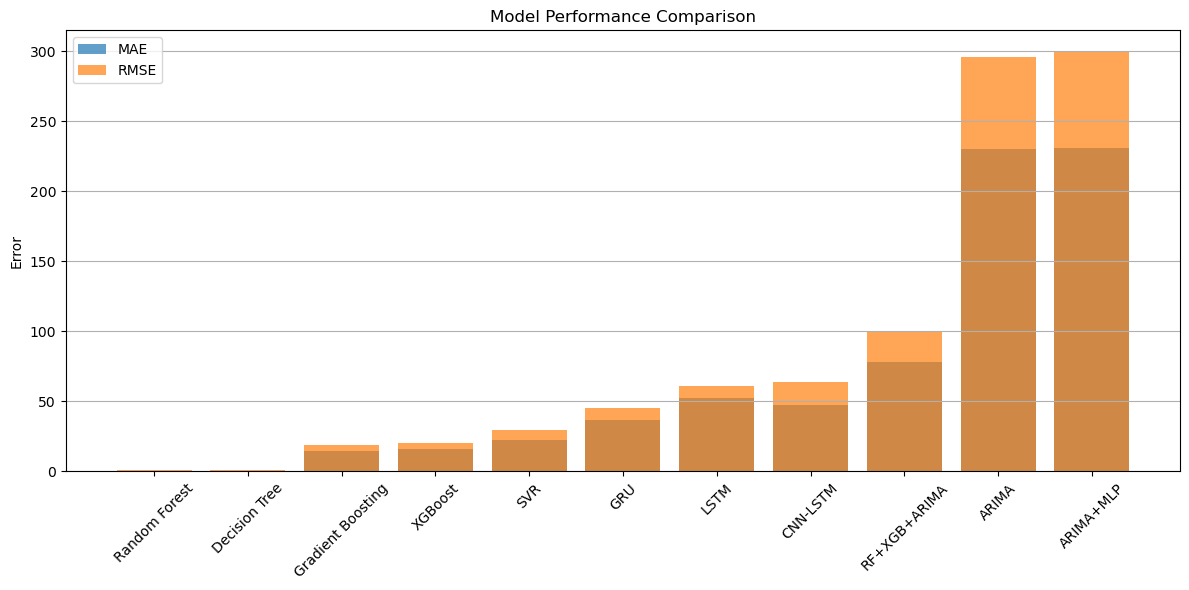

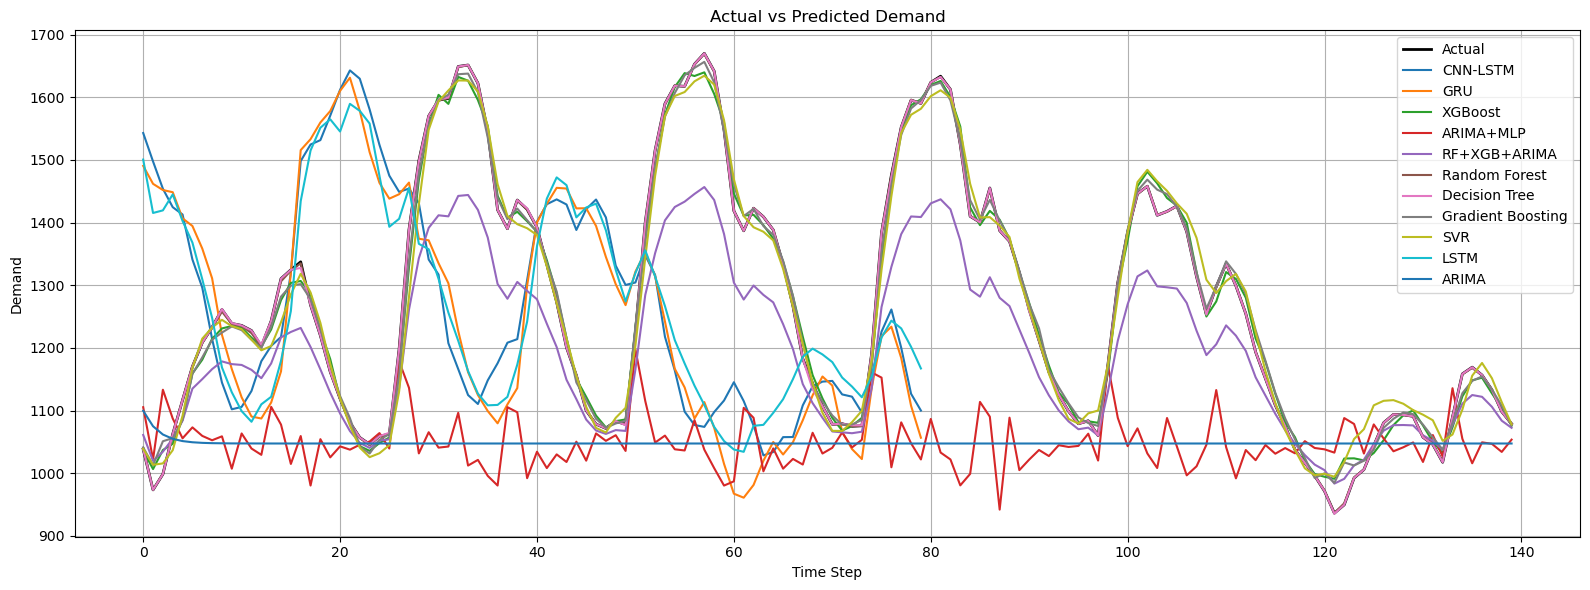

In [50]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load test dataset
test_df = pd.read_excel("./data/test_dataframes.xlsx")

# Parse datetime and set index
if "datetime" in test_df.columns:
    test_df["datetime"] = pd.to_datetime(test_df["datetime"])
    test_df.set_index("datetime", inplace=True)

# Feature engineering
for lag in [1, 7, 14, 21, 28]:
    test_df[f"lag_{lag}"] = test_df["DEMAND"].shift(lag)
for window in [3, 7, 14]:
    test_df[f"rolling_mean_{window}"] = test_df["DEMAND"].rolling(window=window).mean()
test_df["rolling_std_7"] = test_df["DEMAND"].rolling(window=7).std()
test_df["hour"] = test_df.index.hour
test_df["dayofweek"] = test_df.index.dayofweek
test_df["month"] = test_df.index.month
test_df["is_weekend"] = test_df.index.dayofweek.isin([5, 6]).astype(int)

test_df.dropna(inplace=True)

# Define features and targets
TARGET = "DEMAND"
features = [col for col in test_df.columns if col != TARGET]
X_test = test_df[features]
y_test = test_df[TARGET]

# CNN-LSTM / GRU / LSTM dataset prep
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))
time_step = 60
X_test_lstm, y_test_lstm = create_dataset(y_test_scaled, time_step)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

results = []
predictions_dict = {}  # For storing actual vs predicted

# Evaluate DL models
def evaluate_dl_model(model_path, name):
    model = load_model(model_path)
    pred = model.predict(X_test_lstm)
    pred_inv = scaler.inverse_transform(pred)
    y_inv = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
    mae = mean_absolute_error(y_inv, pred_inv)
    rmse = np.sqrt(mean_squared_error(y_inv, pred_inv))
    results.append((name, mae, rmse))
    predictions_dict[name] = pred_inv.flatten()

evaluate_dl_model("./model_weights/cnn_lstm_model.h5", "CNN-LSTM")
evaluate_dl_model("./model_weights/gru_model.h5", "GRU")
evaluate_dl_model("./model_weights/lstm_model.h5", "LSTM")

# Evaluate ML models
def evaluate_ml_model(model, name):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    results.append((name, mae, rmse))
    predictions_dict[name] = pred.flatten()

models_ml = {
    "XGBoost": joblib.load("./model_weights/tuned_xgb_model.pkl"),
    "Random Forest": joblib.load("./model_weights/tuned_random_forest_model.pkl"),
    "Decision Tree": joblib.load("./model_weights/tuned_decision_tree_model.pkl"),
    "Gradient Boosting": joblib.load("./model_weights/tuned_gradient_boosting_model.pkl"),
    "SVR": joblib.load("./model_weights/svr_rbf_model.pkl"),
}

for name, model in models_ml.items():
    evaluate_ml_model(model, name)

# ARIMA
arima = joblib.load("./model_weights/arima_model.pkl")
arima_pred = arima.forecast(steps=len(X_test))
results.append(("ARIMA", mean_absolute_error(y_test, arima_pred), np.sqrt(mean_squared_error(y_test, arima_pred))))
predictions_dict["ARIMA"] = arima_pred.values
# ARIMA-MLP Hybrid
arima_h, mlp_h = joblib.load("./model_weights/arima_mlp_hybrid_arima_part.pkl"), joblib.load("./model_weights/arima_mlp_hybrid_mlp_part.pkl")
arima_pred = arima_h.forecast(steps=len(X_test))
mlp_residual = mlp_h.predict(X_test)
hybrid_pred = arima_pred + mlp_residual
results.append(("ARIMA+MLP", mean_absolute_error(y_test, hybrid_pred), np.sqrt(mean_squared_error(y_test, hybrid_pred))))
predictions_dict["ARIMA+MLP"] = hybrid_pred.values

# RF+XGB+ARIMA Hybrid
rf_h, xgb_h, arima_h = joblib.load("./model_weights/hybrid2_rf_model.pkl"), joblib.load("./model_weights/hybrid2_xgb_model.pkl"), joblib.load("./model_weights/hybrid2_arima_model.pkl")
hybrid2_pred = (rf_h.predict(X_test) + xgb_h.predict(X_test) + arima_h.forecast(steps=len(X_test))) / 3
results.append(("RF+XGB+ARIMA", mean_absolute_error(y_test, hybrid2_pred), np.sqrt(mean_squared_error(y_test, hybrid2_pred))))
predictions_dict["RF+XGB+ARIMA"] = hybrid2_pred.values

# ---------------- Plot Errors ---------------- #
df_results = pd.DataFrame(results, columns=["Model", "MAE", "RMSE"]).sort_values(by="RMSE")
print(df_results)

plt.figure(figsize=(12, 6))
plt.bar(df_results["Model"], df_results["MAE"], alpha=0.7, label="MAE")
plt.bar(df_results["Model"], df_results["RMSE"], alpha=0.7, label="RMSE")
plt.title("Model Performance Comparison")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis="y")
plt.show()

# ---------------- Plot Actual vs Predicted ---------------- #
# Choose a few models to visualize
selected_models = ["CNN-LSTM", "GRU", "XGBoost", "ARIMA+MLP", "RF+XGB+ARIMA","Random Forest","Decision Tree","Gradient Boosting","SVR","LSTM","ARIMA"]

plt.figure(figsize=(16, 6))
start_idx = -300  # Adjust to control how many points to show
true_values = y_test.values[start_idx:]
plt.plot(true_values, label="Actual", linewidth=2, color='black')

for model in selected_models:
    pred_vals = predictions_dict[model]
    aligned_pred = pred_vals[-len(true_values):]
    plt.plot(aligned_pred, label=model)

plt.title("Actual vs Predicted Demand")
plt.xlabel("Time Step")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


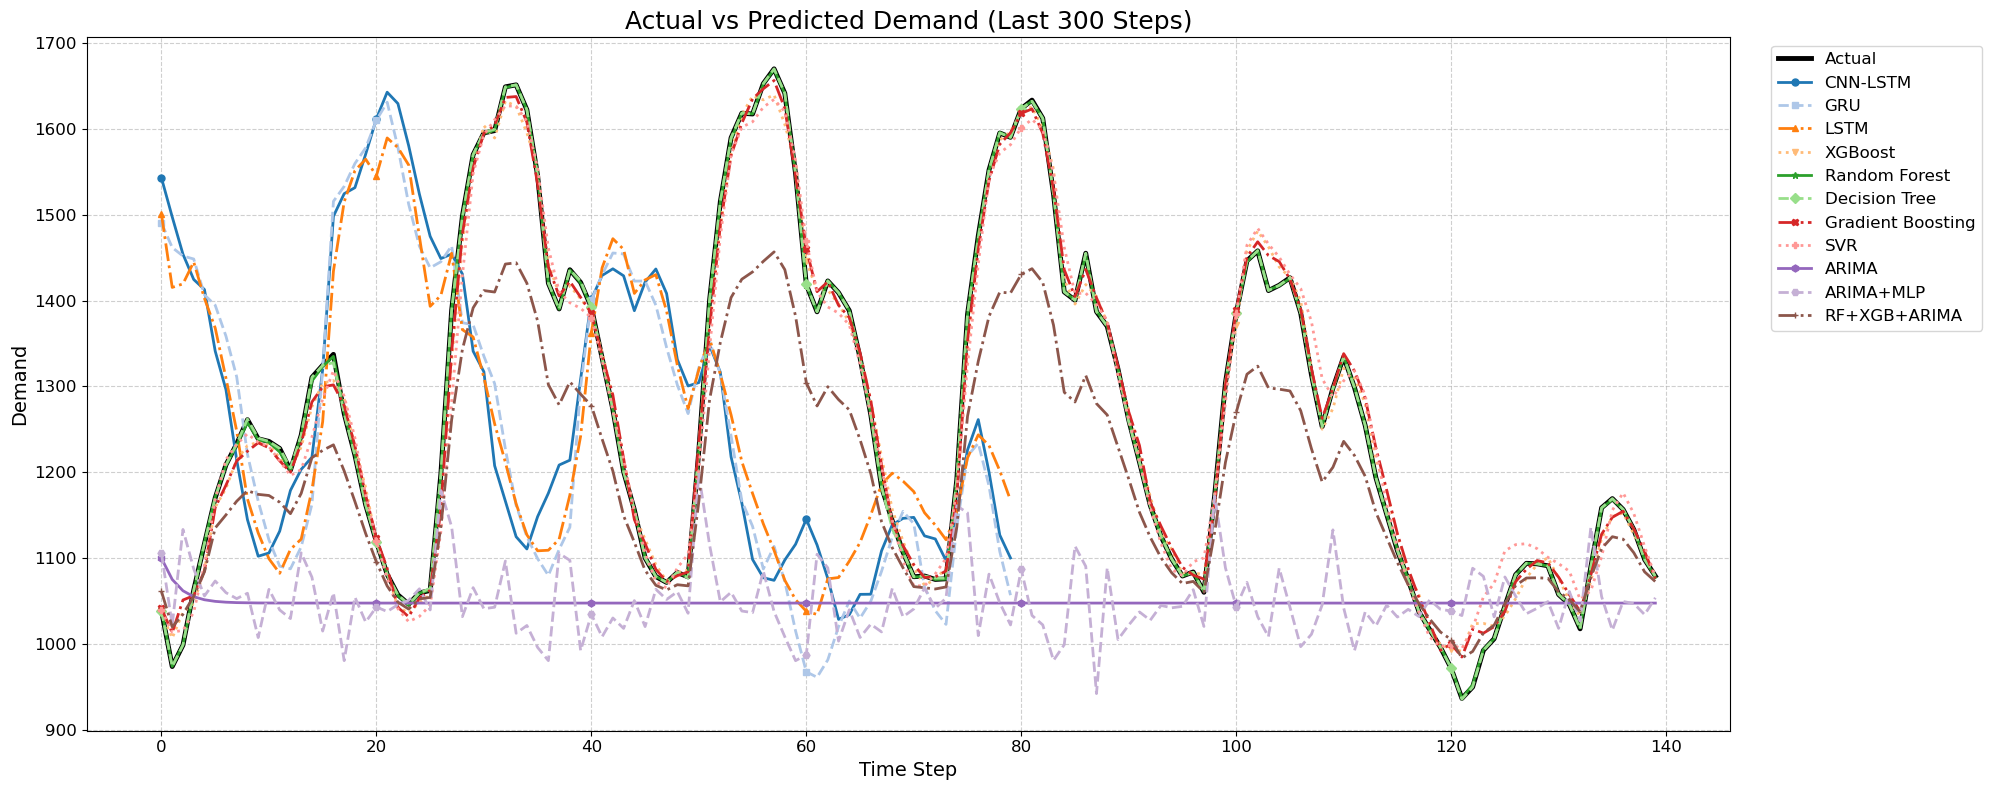

In [51]:
import matplotlib.cm as cm

selected_models = ["CNN-LSTM", "GRU", "LSTM", "XGBoost", "Random Forest", "Decision Tree",
                   "Gradient Boosting", "SVR", "ARIMA", "ARIMA+MLP", "RF+XGB+ARIMA"]

# Prepare figure
plt.figure(figsize=(20, 8))
start_idx = -300  # Number of test points to display
true_values = y_test.values[start_idx:]

# Actual
plt.plot(true_values, label="Actual", linewidth=3.5, color='black', linestyle='-')

# Distinct colors and line styles
colors = cm.tab20.colors  # 20 distinct colors
linestyles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'v', '*', 'D', 'X', 'P', 'h', 'H', '+']

# Plot predictions
for i, model in enumerate(selected_models):
    pred_vals = predictions_dict[model]
    aligned_pred = pred_vals[-len(true_values):]
    plt.plot(aligned_pred,
             label=model,
             linewidth=2,
             color=colors[i % len(colors)],
             linestyle=linestyles[i % len(linestyles)],
             marker=markers[i % len(markers)],
             markevery=20,  # Sparse markers
             markersize=5)

# Format
plt.title("Actual vs Predicted Demand (Last 300 Steps)", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Demand", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), fontsize=12, ncol=1)
plt.tight_layout()
plt.show()


In [81]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

# ---------------- Utility Functions ---------------- #
def mean_percentage_absolute_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# ---------------- Load & Prepare Test Data ---------------- #

# ------------------- Iterate Through All Sheets ------------------- #
xls = pd.ExcelFile("./data/test_dataframes.xlsx")
sheet_names = xls.sheet_names
sheet = sheet_names[14]
test_df = xls.parse(sheet)

if "datetime" in test_df.columns:
    test_df["datetime"] = pd.to_datetime(test_df["datetime"])
    test_df.set_index("datetime", inplace=True)

# Feature engineering
for lag in [1, 7, 14, 21, 28]:
    test_df[f"lag_{lag}"] = test_df["DEMAND"].shift(lag)
for window in [3, 7, 14]:
    test_df[f"rolling_mean_{window}"] = test_df["DEMAND"].rolling(window=window).mean()
test_df["rolling_std_7"] = test_df["DEMAND"].rolling(window=7).std()
test_df["hour"] = test_df.index.hour
test_df["dayofweek"] = test_df.index.dayofweek
test_df["month"] = test_df.index.month
test_df["is_weekend"] = test_df.index.dayofweek.isin([5, 6]).astype(int)

test_df.dropna(inplace=True)

TARGET = "DEMAND"
features = [col for col in test_df.columns if col != TARGET]
X_test = test_df[features]
y_test = test_df[TARGET]

# ---------------- Prepare LSTM Dataset ---------------- #
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))
time_step = 60
X_test_lstm, y_test_lstm = create_dataset(y_test_scaled, time_step)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

results = []
predictions_dict = {}

# ---------------- DL Model Evaluation ---------------- #
def evaluate_dl_model(model_path, name):
    model = load_model(model_path)
    pred = model.predict(X_test_lstm)
    pred_inv = scaler.inverse_transform(pred)
    y_inv = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
    mae = mean_absolute_error(y_inv, pred_inv)
    rmse = np.sqrt(mean_squared_error(y_inv, pred_inv))
    mpae = mean_percentage_absolute_error(y_inv, pred_inv)
    results.append((name, mae, rmse, mpae))
    predictions_dict[name] = pred_inv.flatten()

evaluate_dl_model("./model_weights/cnn_lstm_model.h5", "CNN-LSTM")
evaluate_dl_model("./model_weights/gru_model.h5", "GRU")
evaluate_dl_model("./model_weights/lstm_model.h5", "LSTM")

# ---------------- ML Model Evaluation ---------------- #
def evaluate_ml_model(model, name):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mpae = mean_percentage_absolute_error(y_test.values, pred)
    results.append((name, mae, rmse, mpae))
    predictions_dict[name] = pred.flatten()

models_ml = {
    "XGBoost": joblib.load("./model_weights/tuned_xgb_model.pkl"),
    "Random Forest": joblib.load("./model_weights/tuned_random_forest_model.pkl"),
    "Decision Tree": joblib.load("./model_weights/tuned_decision_tree_model.pkl"),
    "Gradient Boosting": joblib.load("./model_weights/tuned_gradient_boosting_model.pkl"),
    "SVR": joblib.load("./model_weights/svr_rbf_model.pkl"),
}

for name, model in models_ml.items():
    evaluate_ml_model(model, name)

# ---------------- Hybrid Model Evaluation ---------------- #
# ARIMA
arima = joblib.load("./model_weights/arima_model.pkl")
arima_pred = arima.forecast(steps=len(X_test))
mae = mean_absolute_error(y_test, arima_pred)
rmse = np.sqrt(mean_squared_error(y_test, arima_pred))
mpae = mean_percentage_absolute_error(y_test.values, arima_pred)
results.append(("ARIMA", mae, rmse, mpae))
predictions_dict["ARIMA"] = arima_pred.values

# ARIMA+MLP
arima_h = joblib.load("./model_weights/arima_mlp_hybrid_arima_part.pkl")
mlp_h = joblib.load("./model_weights/arima_mlp_hybrid_mlp_part.pkl")
arima_pred = arima_h.forecast(steps=len(X_test))
mlp_residual = mlp_h.predict(X_test)
hybrid_pred = arima_pred + mlp_residual
mae = mean_absolute_error(y_test, hybrid_pred)
rmse = np.sqrt(mean_squared_error(y_test, hybrid_pred))
mpae = mean_percentage_absolute_error(y_test.values, hybrid_pred)
results.append(("ARIMA+MLP", mae, rmse, mpae))
predictions_dict["ARIMA+MLP"] = hybrid_pred.values

# RF + XGB + ARIMA
rf_h = joblib.load("./model_weights/hybrid2_rf_model.pkl")
xgb_h = joblib.load("./model_weights/hybrid2_xgb_model.pkl")
arima_h = joblib.load("./model_weights/hybrid2_arima_model.pkl")
hybrid2_pred = (rf_h.predict(X_test) + xgb_h.predict(X_test) + arima_h.forecast(steps=len(X_test))) / 3
mae = mean_absolute_error(y_test, hybrid2_pred)
rmse = np.sqrt(mean_squared_error(y_test, hybrid2_pred))
mpae = mean_percentage_absolute_error(y_test.values, hybrid2_pred)
results.append(("RF+XGB+ARIMA", mae, rmse, mpae))
predictions_dict["RF+XGB+ARIMA"] = hybrid2_pred.values
os.makedirs("results", exist_ok=True)

# ---------------- Performance Comparison Table ---------------- #
df_results = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "MPAE"])
print(df_results)
df_results.to_csv(f"./results/model_results{sheet}.csv", index=False)

# ---------------- Error Metric Bar Plot ---------------- #
plt.figure(figsize=(14, 6))
x = np.arange(len(df_results["Model"]))
width = 0.25

plt.bar(x - width, df_results["MAE"], width, label="MAE")
plt.bar(x, df_results["RMSE"], width, label="RMSE")
plt.bar(x + width, df_results["MPAE"], width, label="MPAE")

plt.xticks(x, df_results["Model"], rotation=45)
plt.ylabel("Error")
plt.title(f"Model Performance Comparison (MAE, RMSE, MPAE)- {sheet}")
plt.legend()
plt.grid(axis="y")
plt.tight_layout()
# Save bar plot
plt.savefig(f"./results/error_metrics_{sheet}.png", dpi=300)
plt.show()
plt.close()

# ---------------- Actual vs Predicted Plot ---------------- #
import matplotlib.cm as cm

selected_models = ["CNN-LSTM", "GRU", "LSTM", "XGBoost", "Random Forest", "Decision Tree",
                   "Gradient Boosting", "SVR", "ARIMA", "ARIMA+MLP", "RF+XGB+ARIMA"]

plt.figure(figsize=(20, 8))
start_idx = -300  # Number of test points to display
true_values = y_test.values[start_idx:]

# Actual demand
plt.plot(true_values, label="Actual", linewidth=3.5, color='black', linestyle='-')

colors = cm.tab20.colors
linestyles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'v', '*', 'D', 'X', 'P', 'h', 'H', '+']

for i, model in enumerate(selected_models):
    pred_vals = predictions_dict[model]
    aligned_pred = pred_vals[-len(true_values):]
    plt.plot(aligned_pred,
             label=model,
             linewidth=2,
             color=colors[i % len(colors)],
             linestyle=linestyles[i % len(linestyles)],
             marker=markers[i % len(markers)],
             markevery=20,
             markersize=5)

plt.title(f"Actual vs Predicted Demand - {sheet}", fontsize=18)
plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Demand", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), fontsize=12)
plt.tight_layout()
# Save actual vs predicted plot
plt.savefig(f"./results/actual_vs_predicted_{sheet}.png", dpi=300)
plt.show()
plt.close()


IndexError: list index out of range

In [82]:
import pandas as pd
import os
import glob

# Folder where your CSVs are stored
folder_path = "results"  # e.g., "results_folder"

# Get all CSV file paths
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Combine them into one DataFrame
combined_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

# Save the combined CSV
combined_df.to_csv("combined_results.csv", index=False)



===== Processing Sheet: Week 15, Apr 2019 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

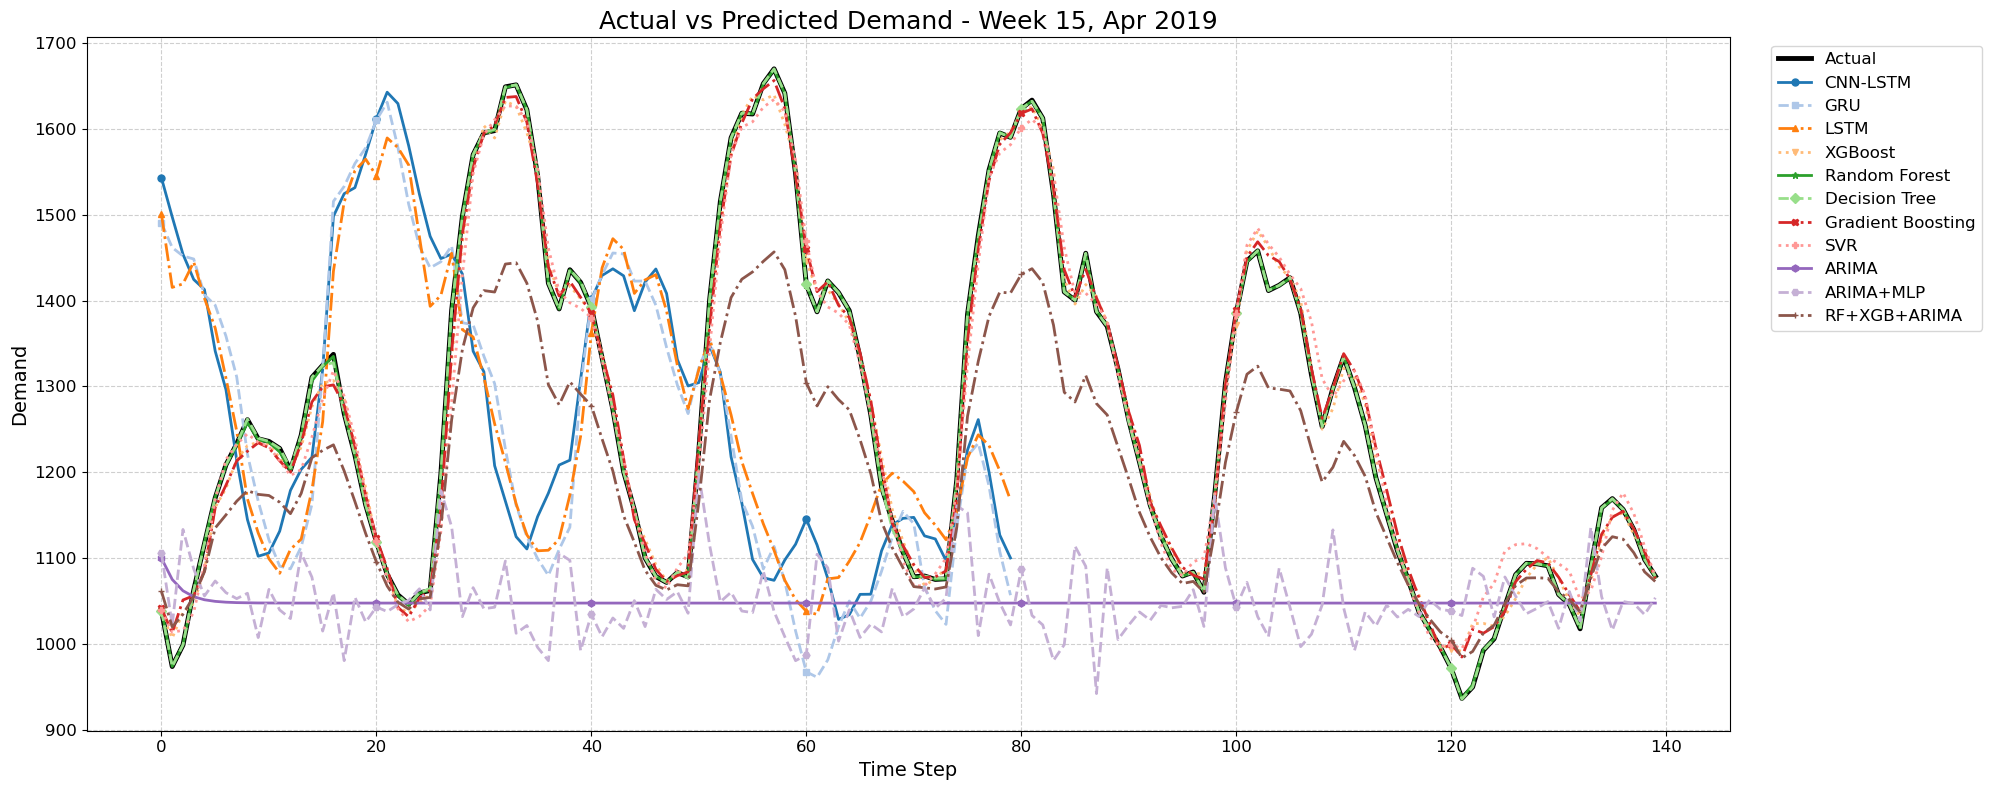


===== Processing Sheet: Week 21, May 2019 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

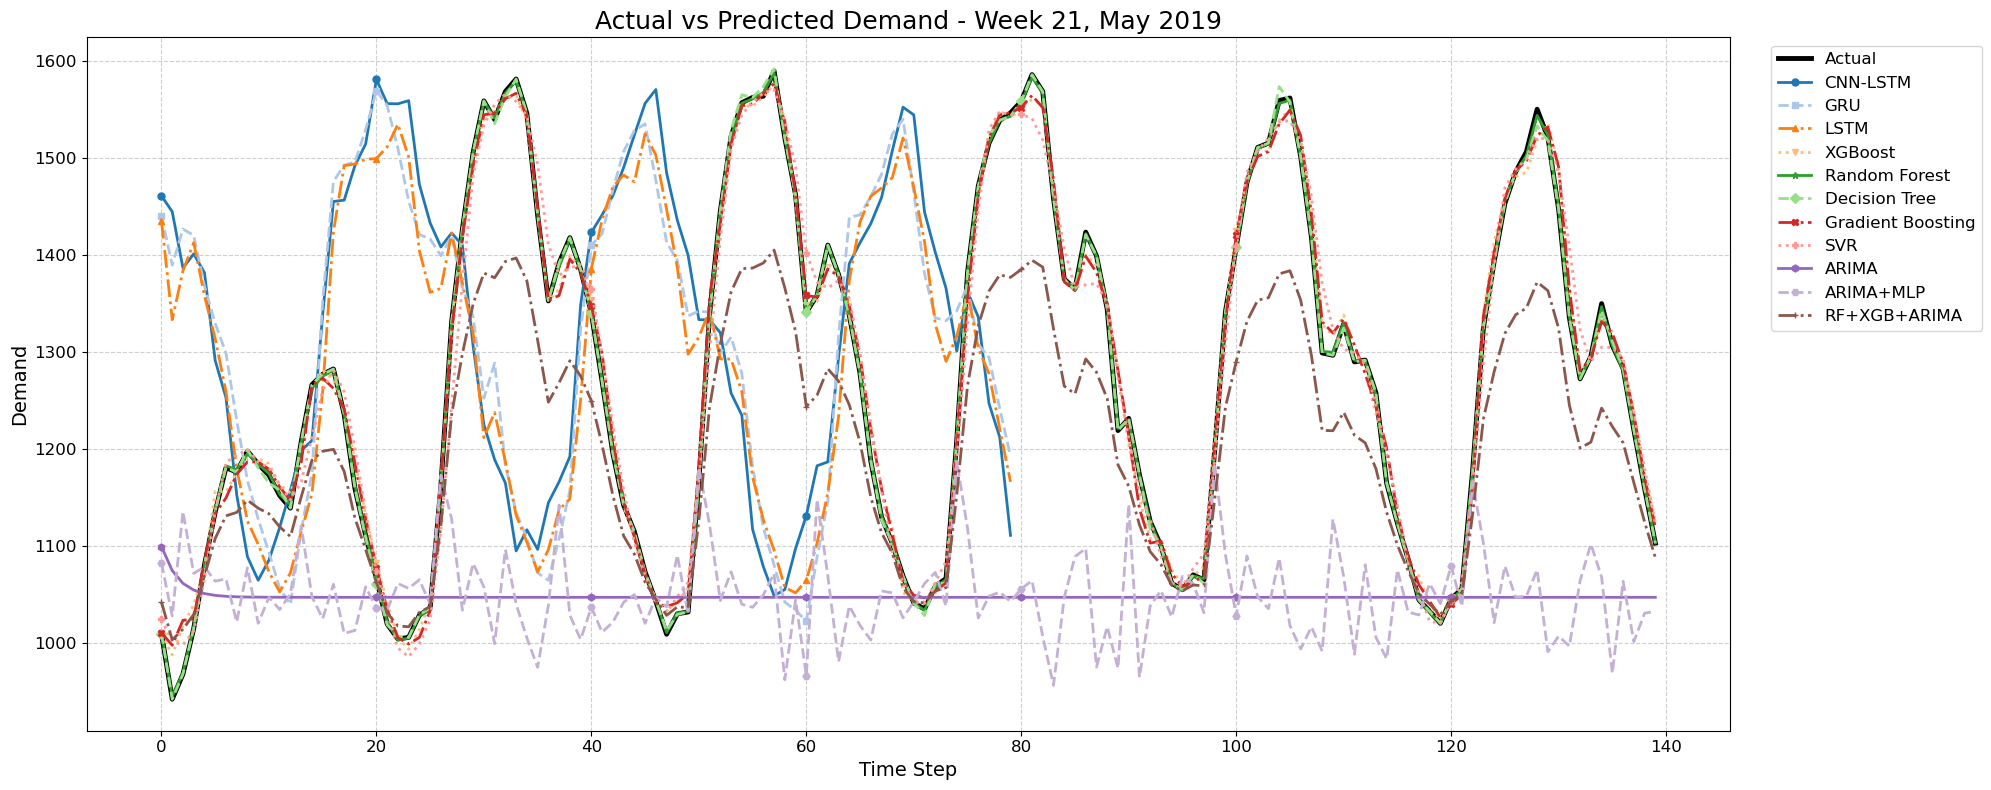


===== Processing Sheet: Week 24, Jun 2019 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

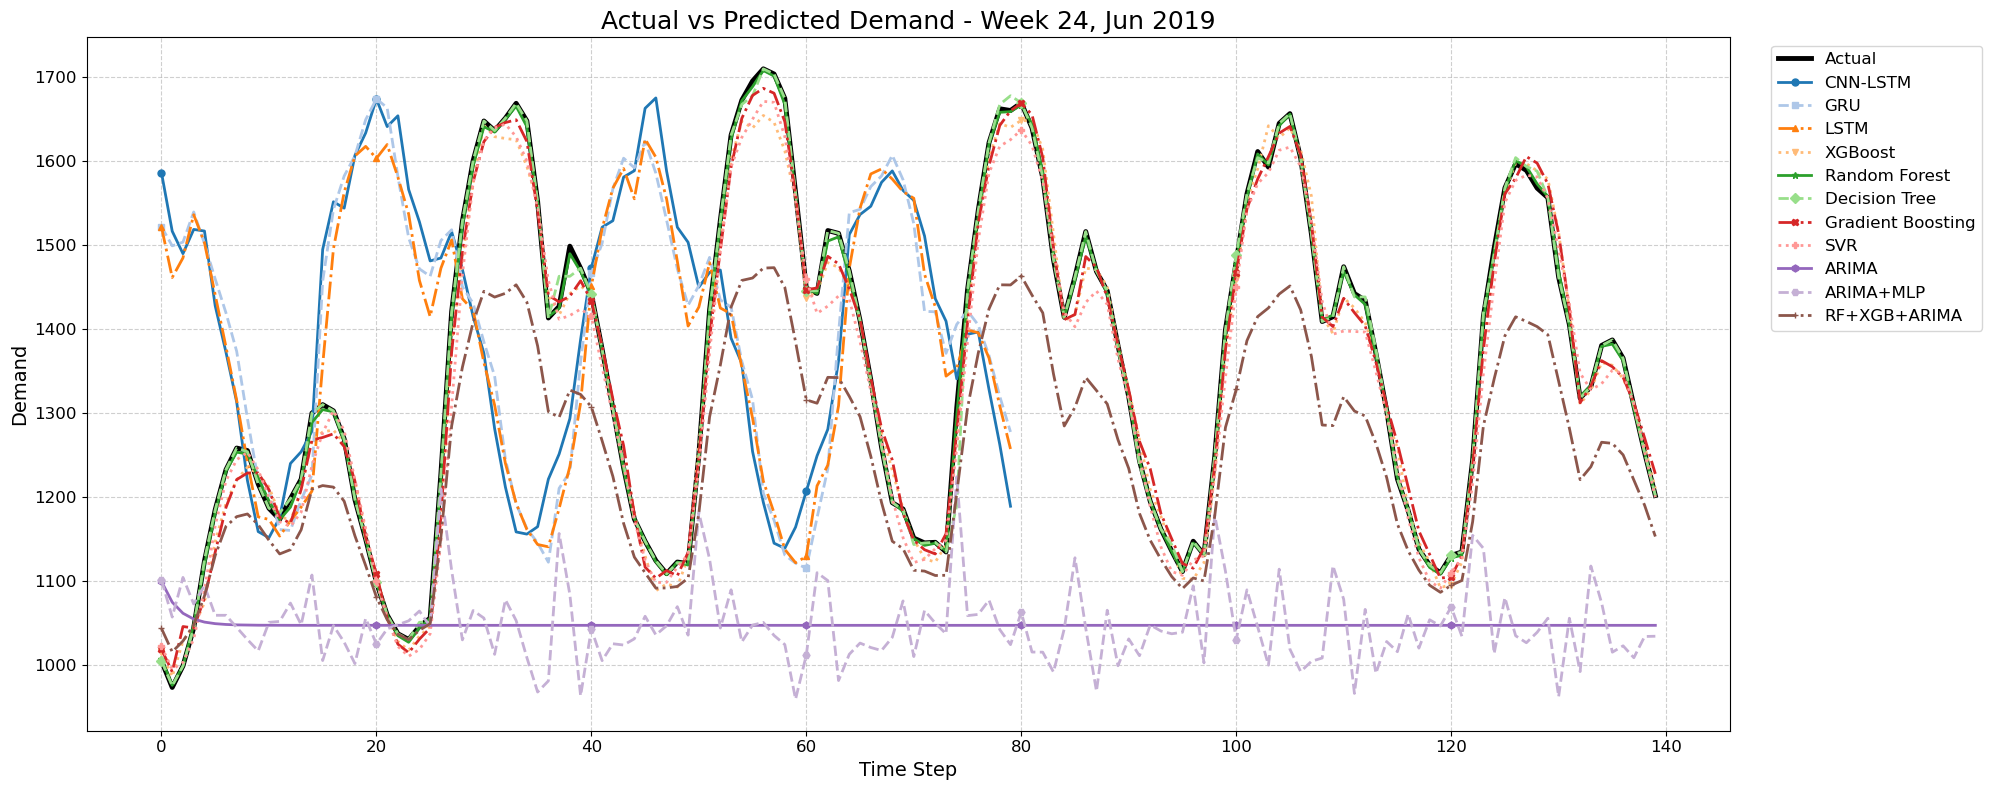


===== Processing Sheet: Week 29, Jul 2019 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

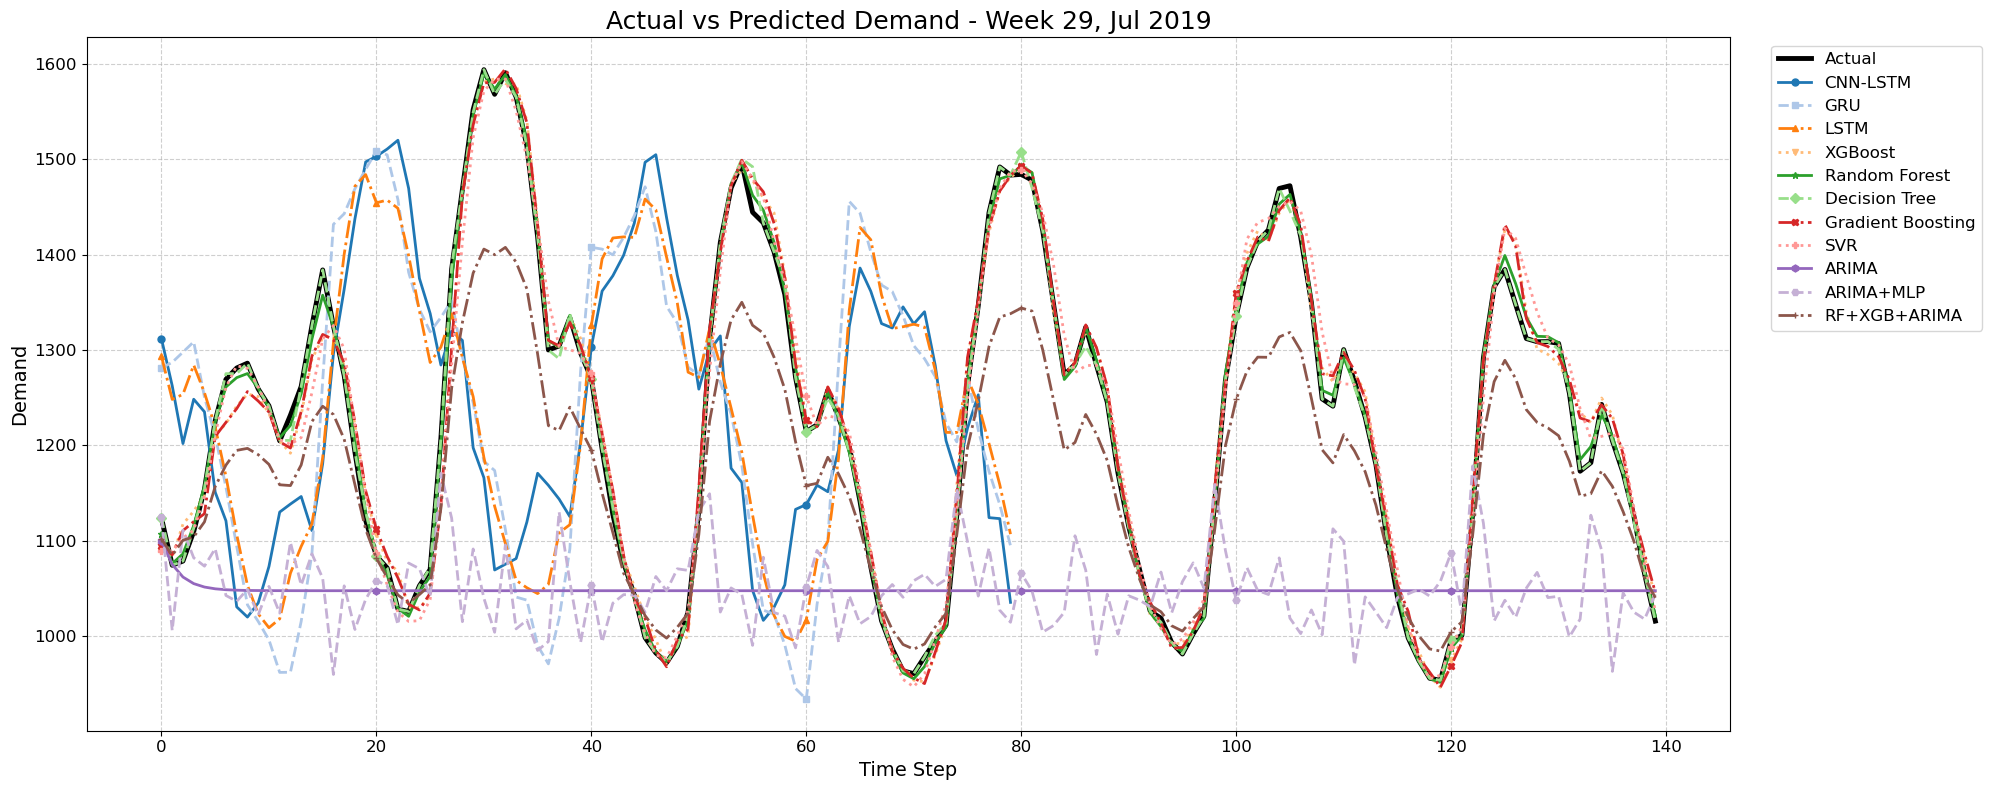


===== Processing Sheet: Week 33, Aug 2019 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

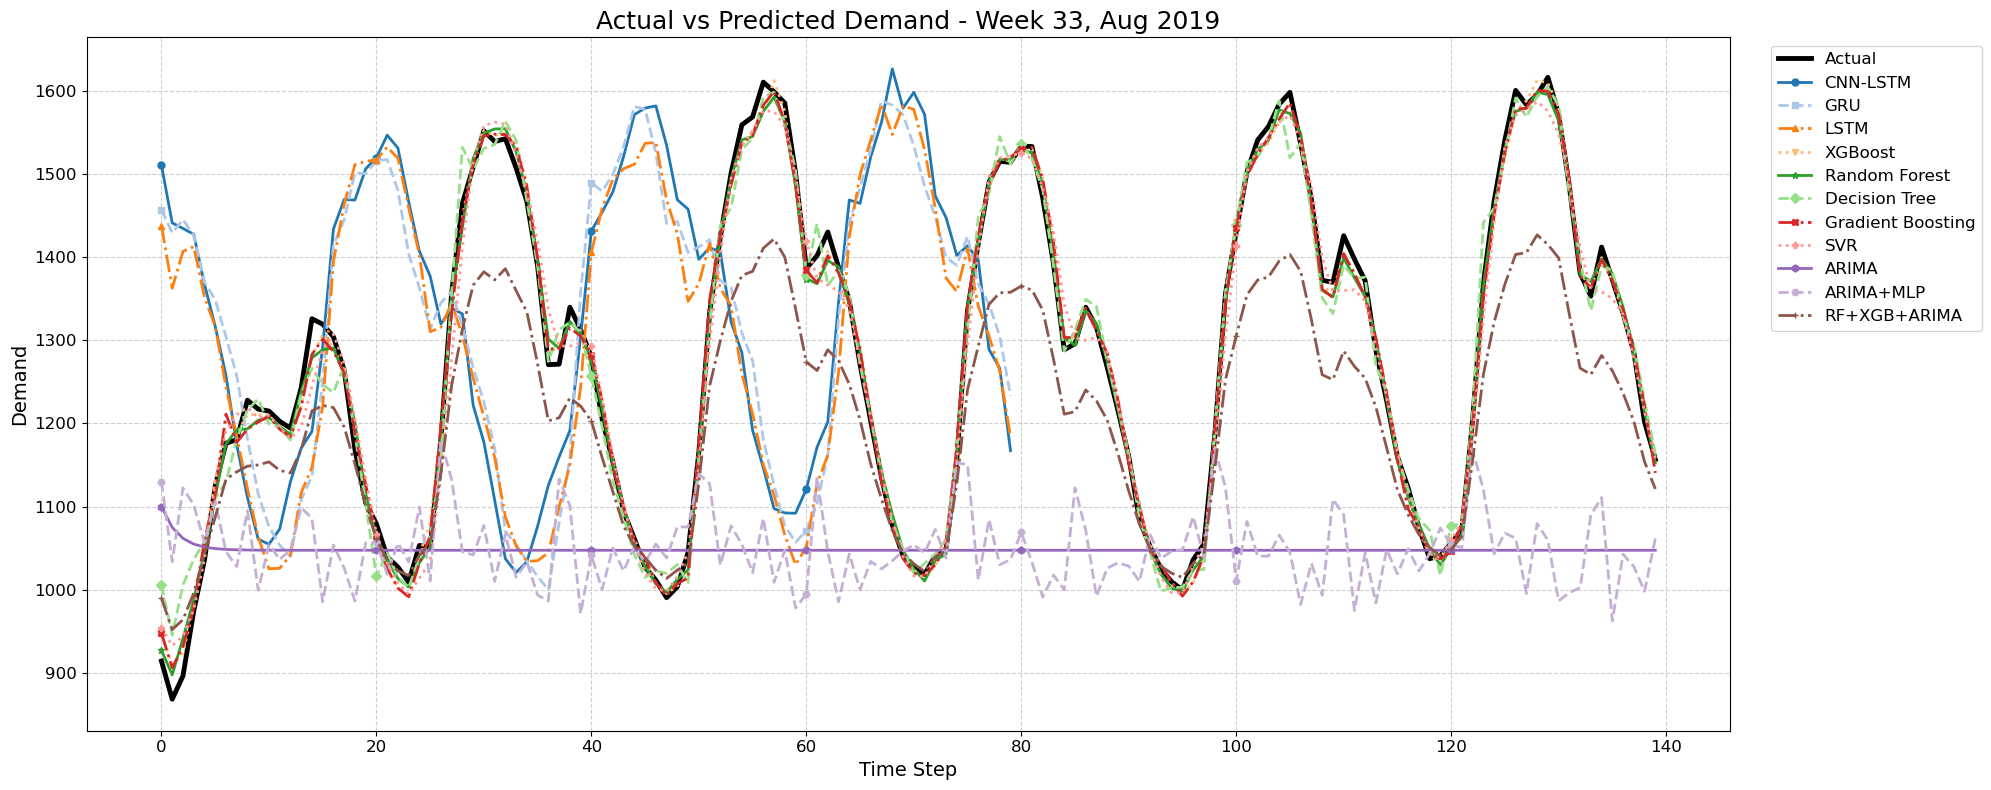


===== Processing Sheet: Week 37, Sep 2019 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

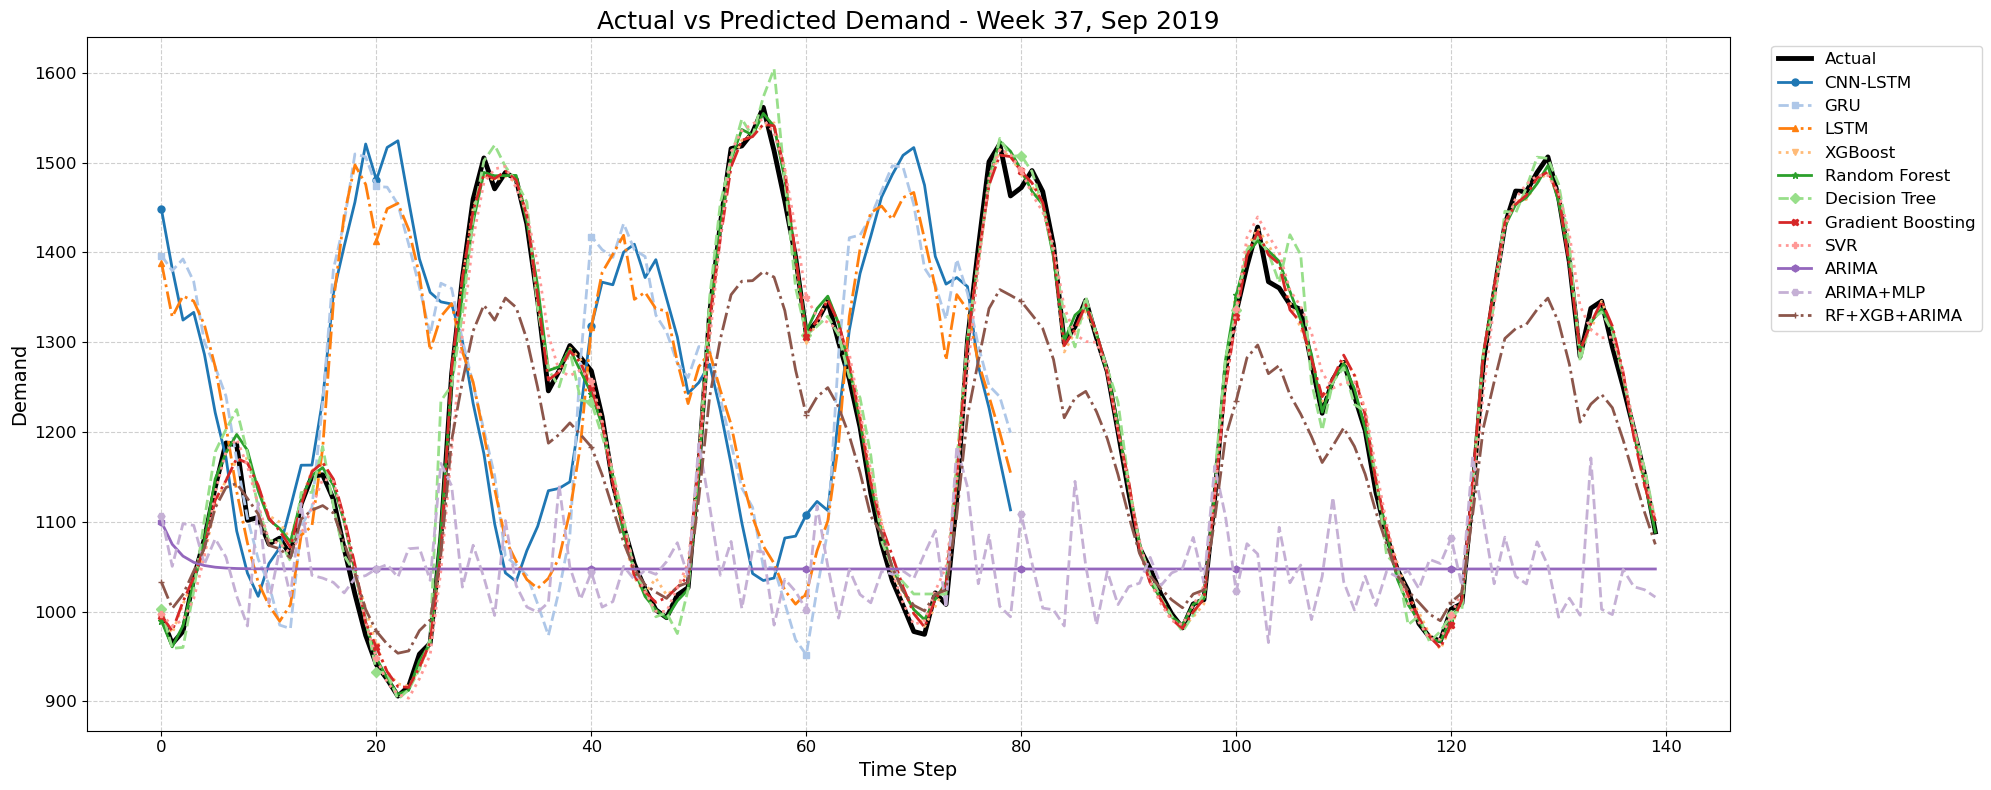


===== Processing Sheet: Week 41, Oct 2019 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

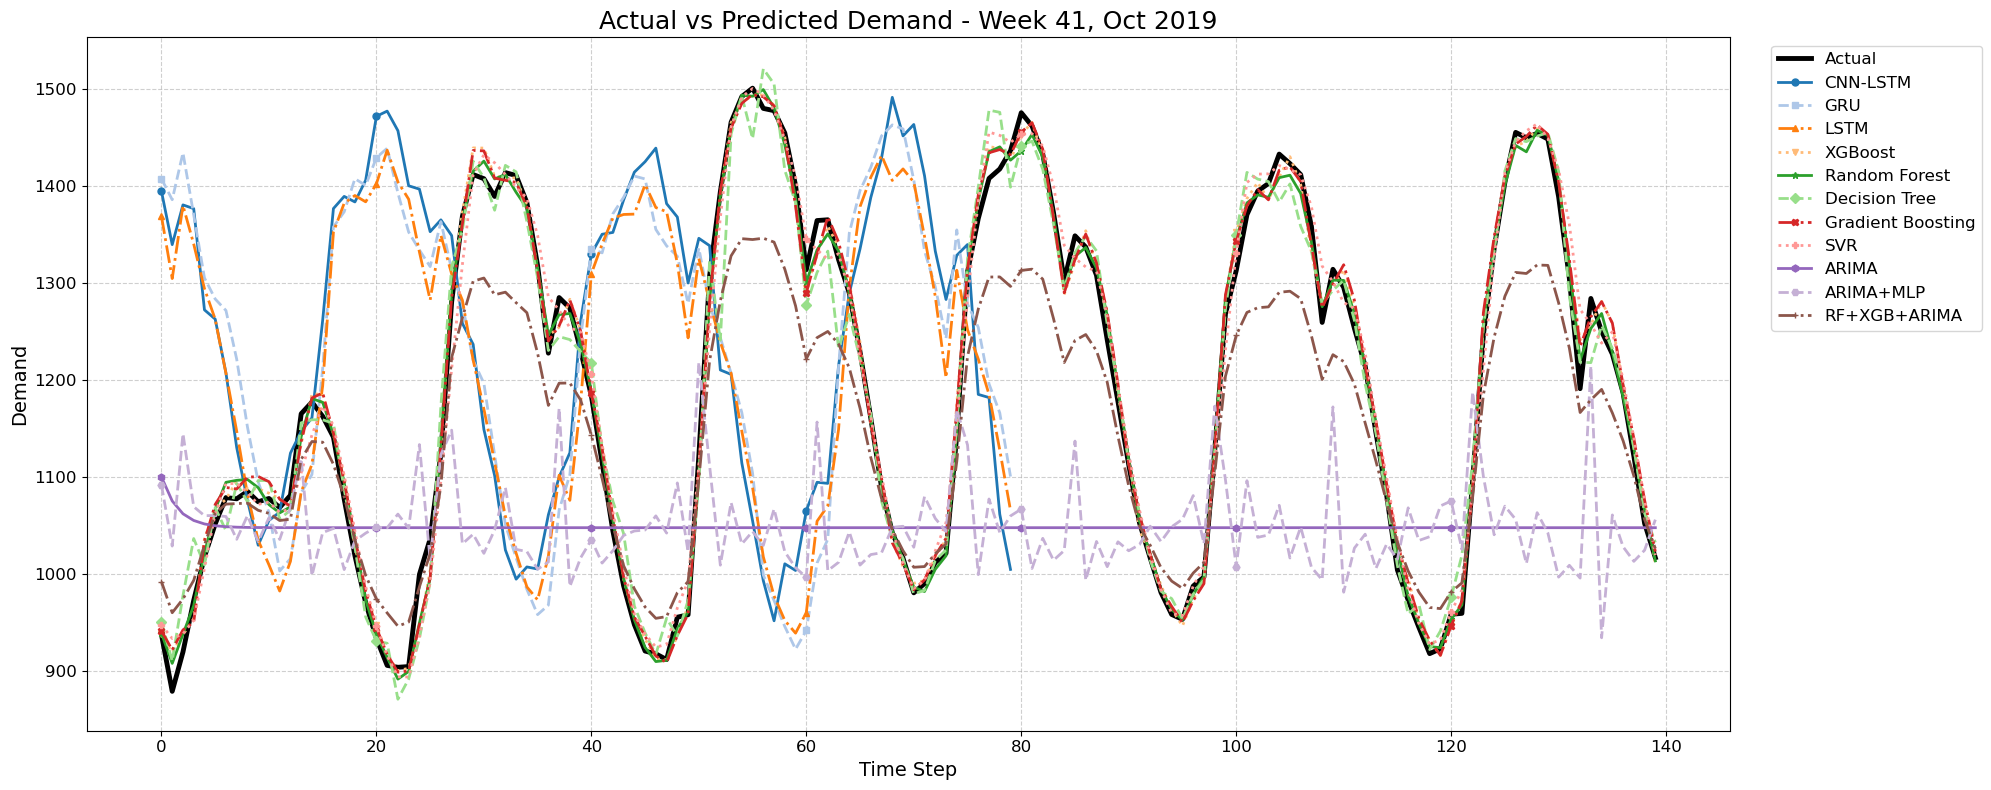


===== Processing Sheet: Week 44, Nov 2019 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

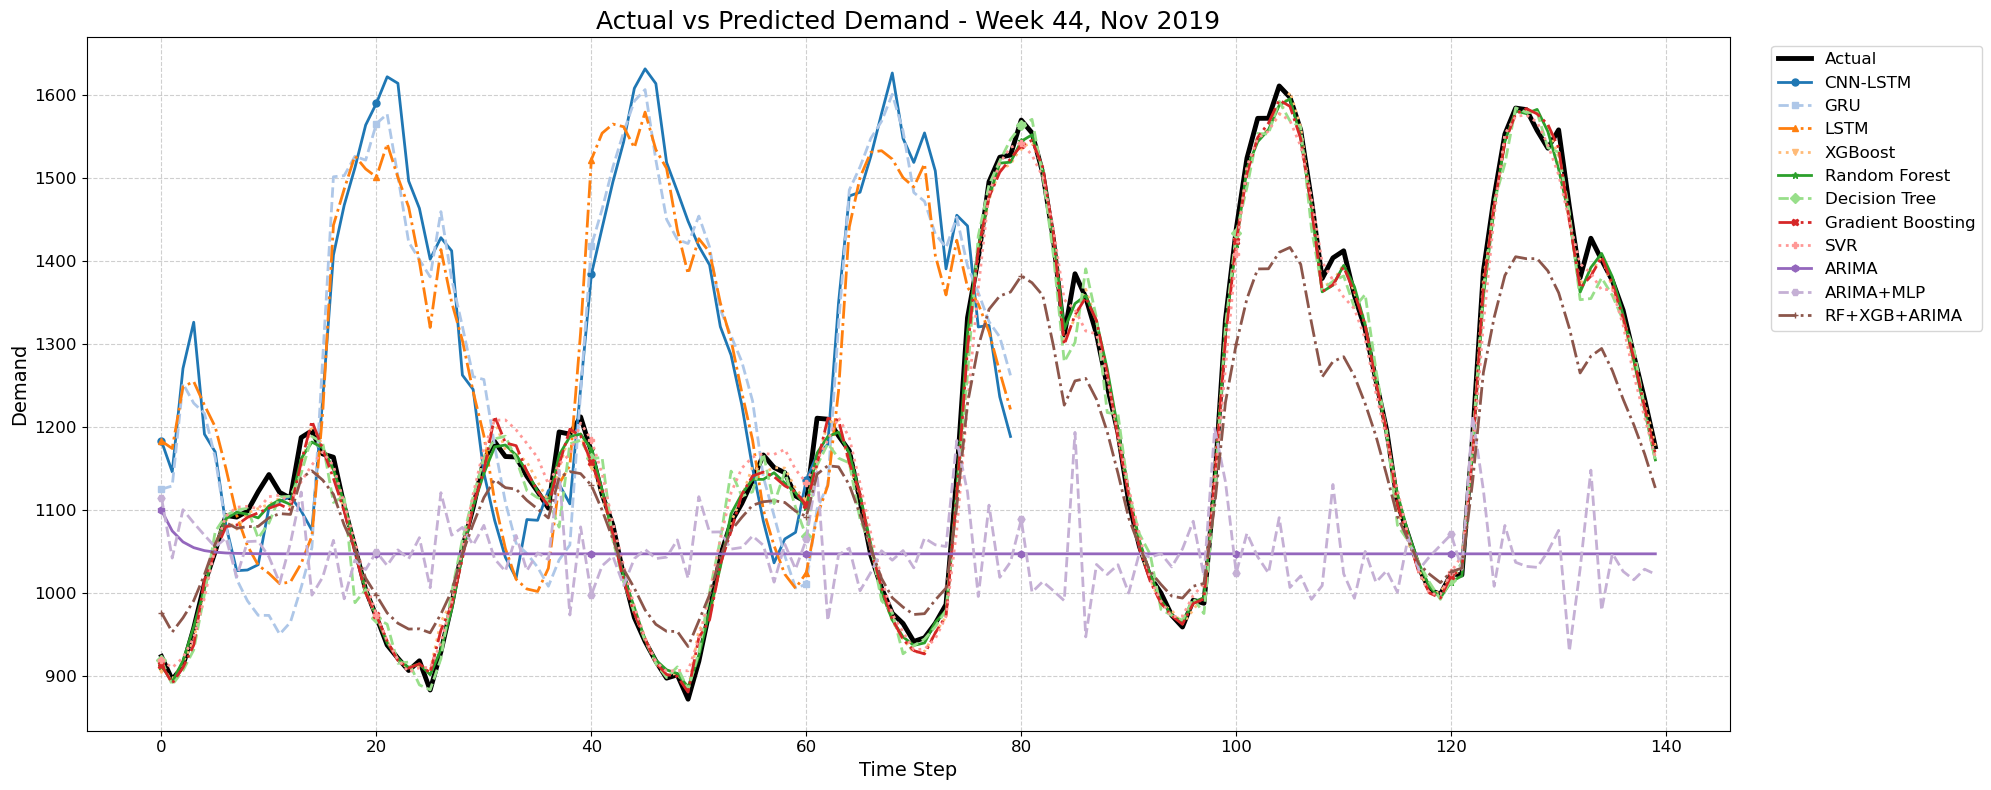


===== Processing Sheet: Week 51, Dec 2019 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

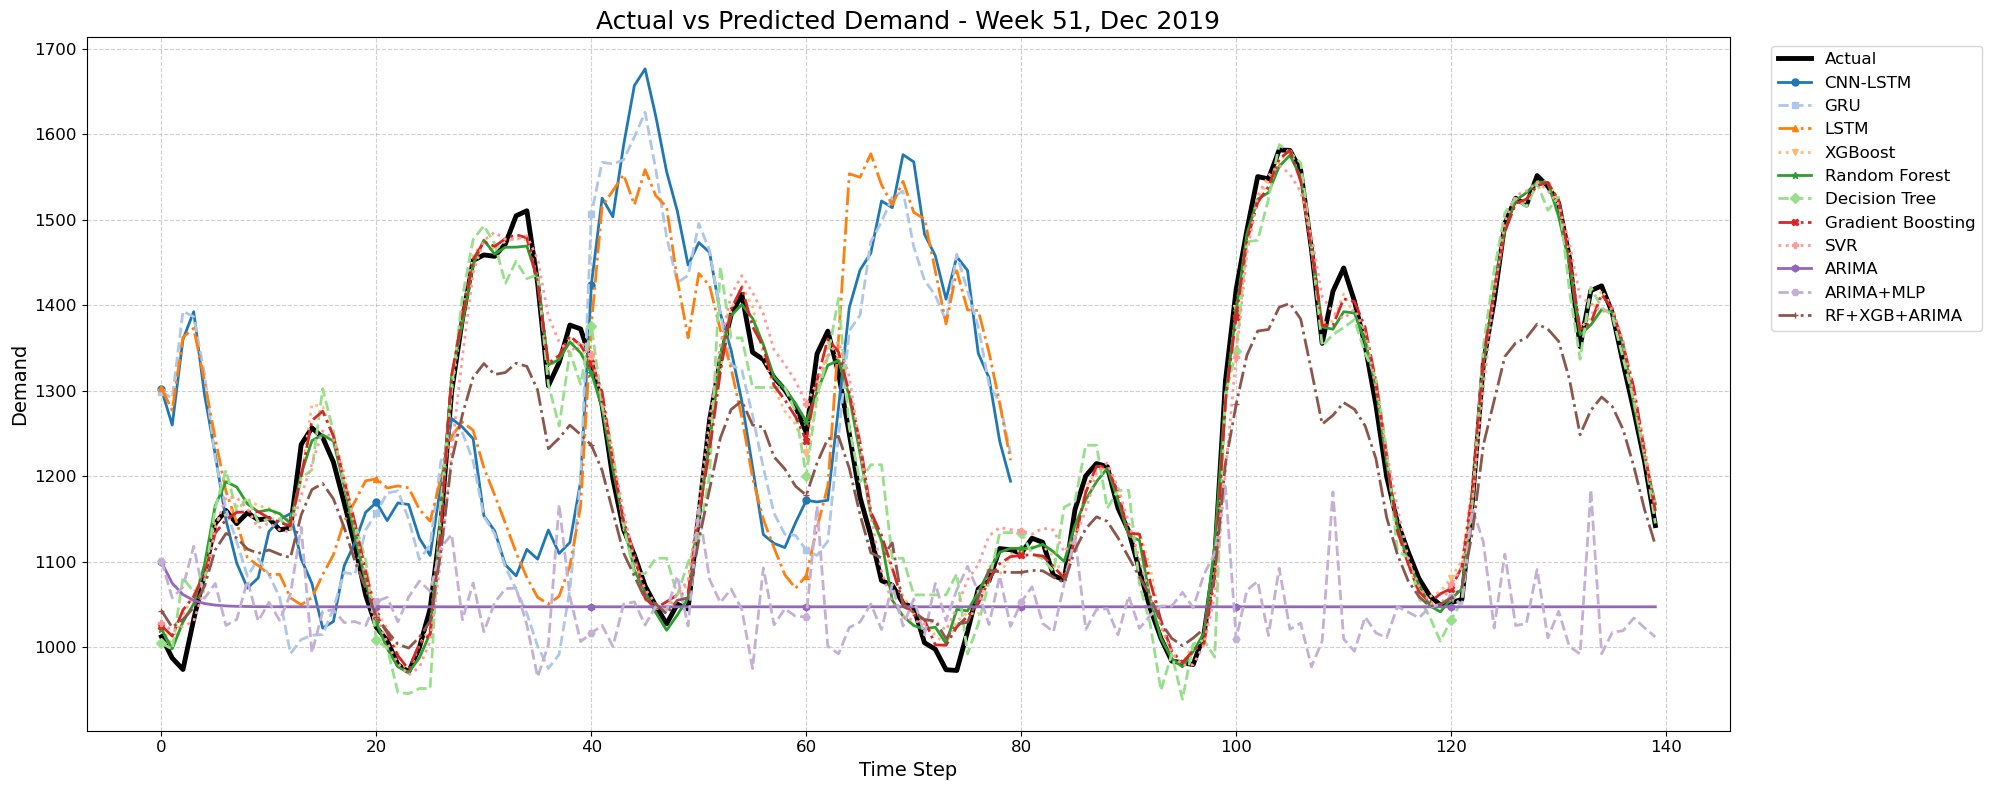


===== Processing Sheet: Week 01, Jan 2020 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

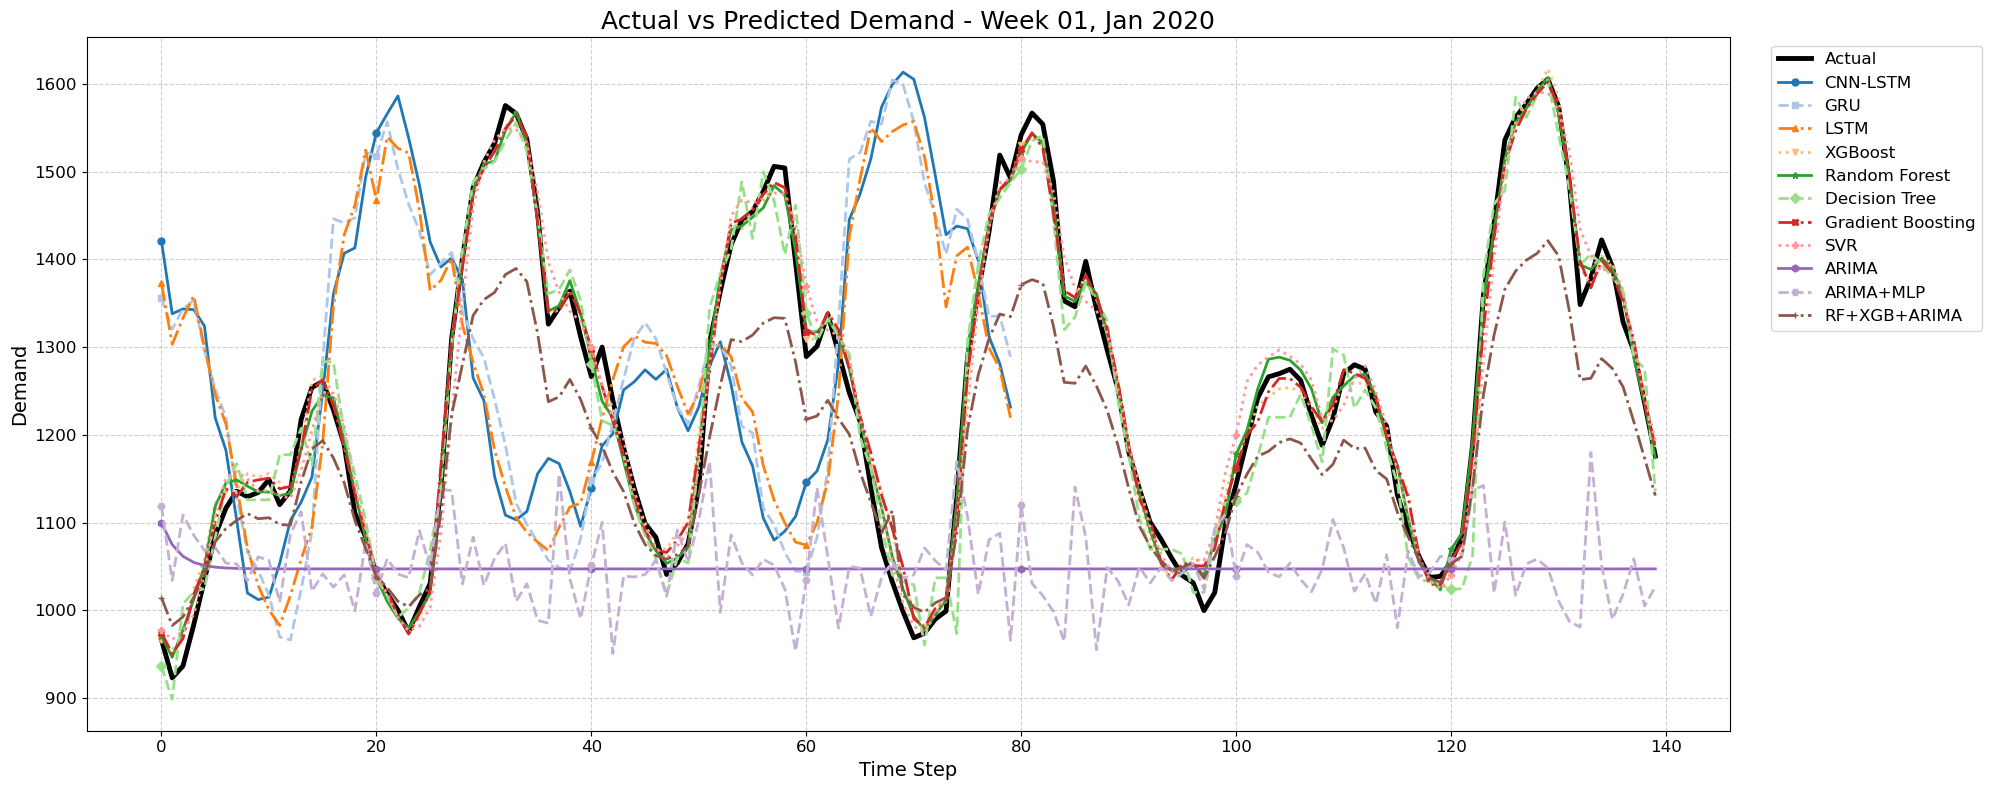


===== Processing Sheet: Week 06, Feb 2020 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

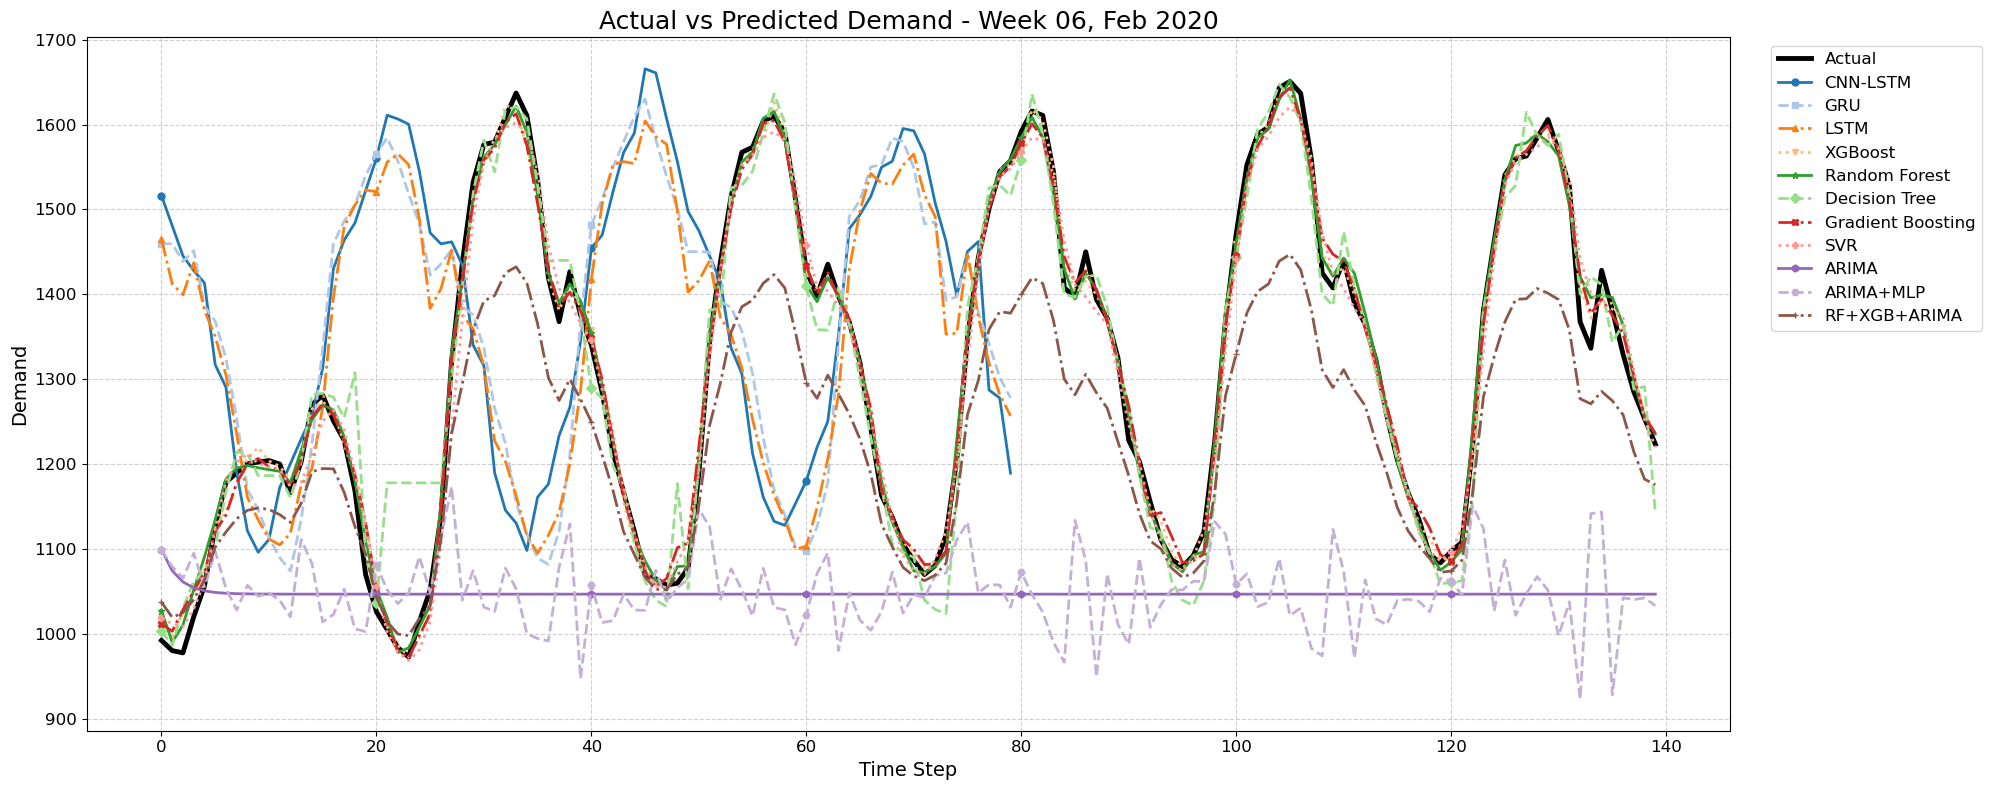


===== Processing Sheet: Week 10, Mar 2020 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

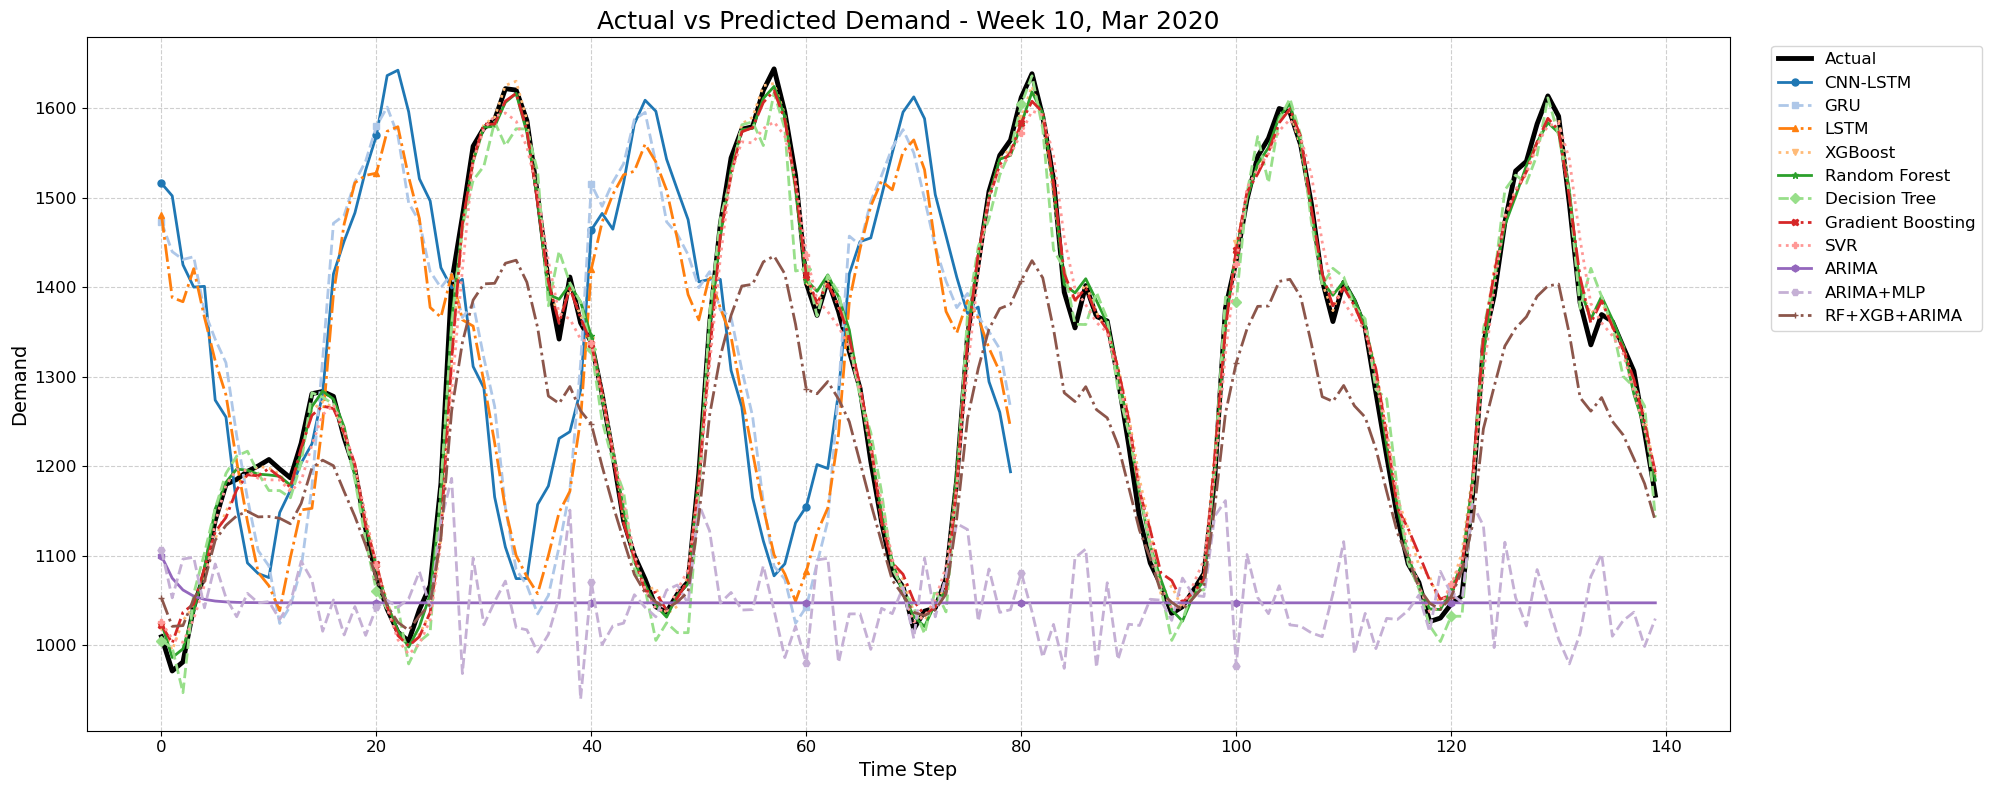


===== Processing Sheet: Week 20, May 2020 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

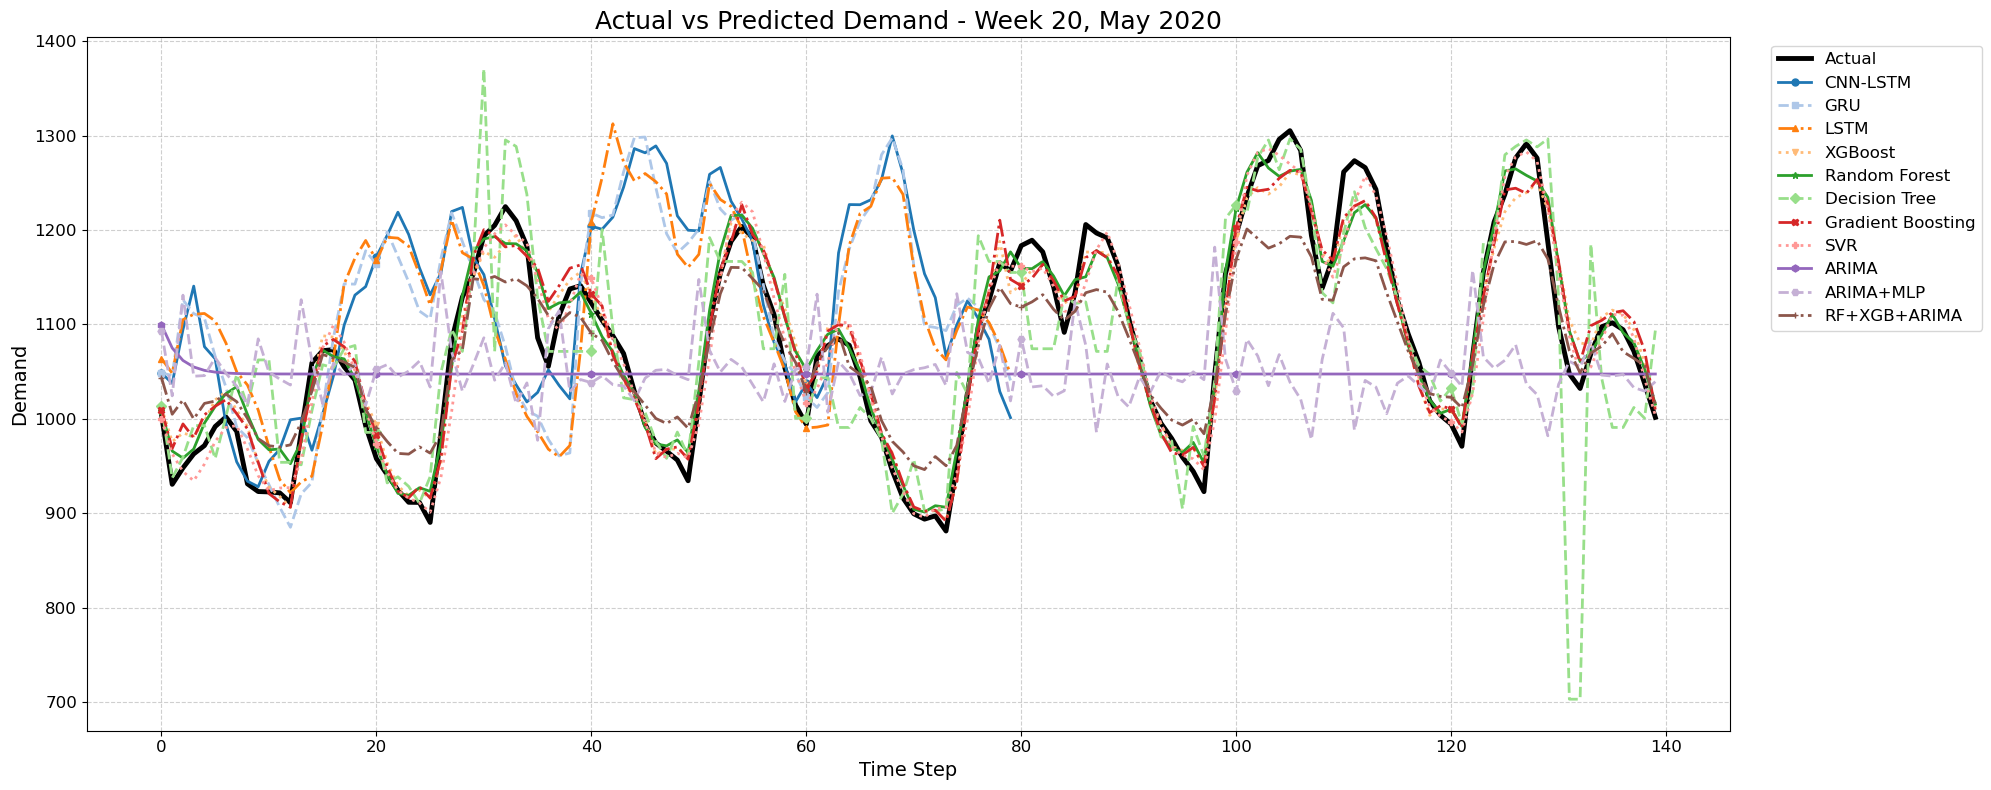


===== Processing Sheet: Week 24, Jun 2020 =====
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/li

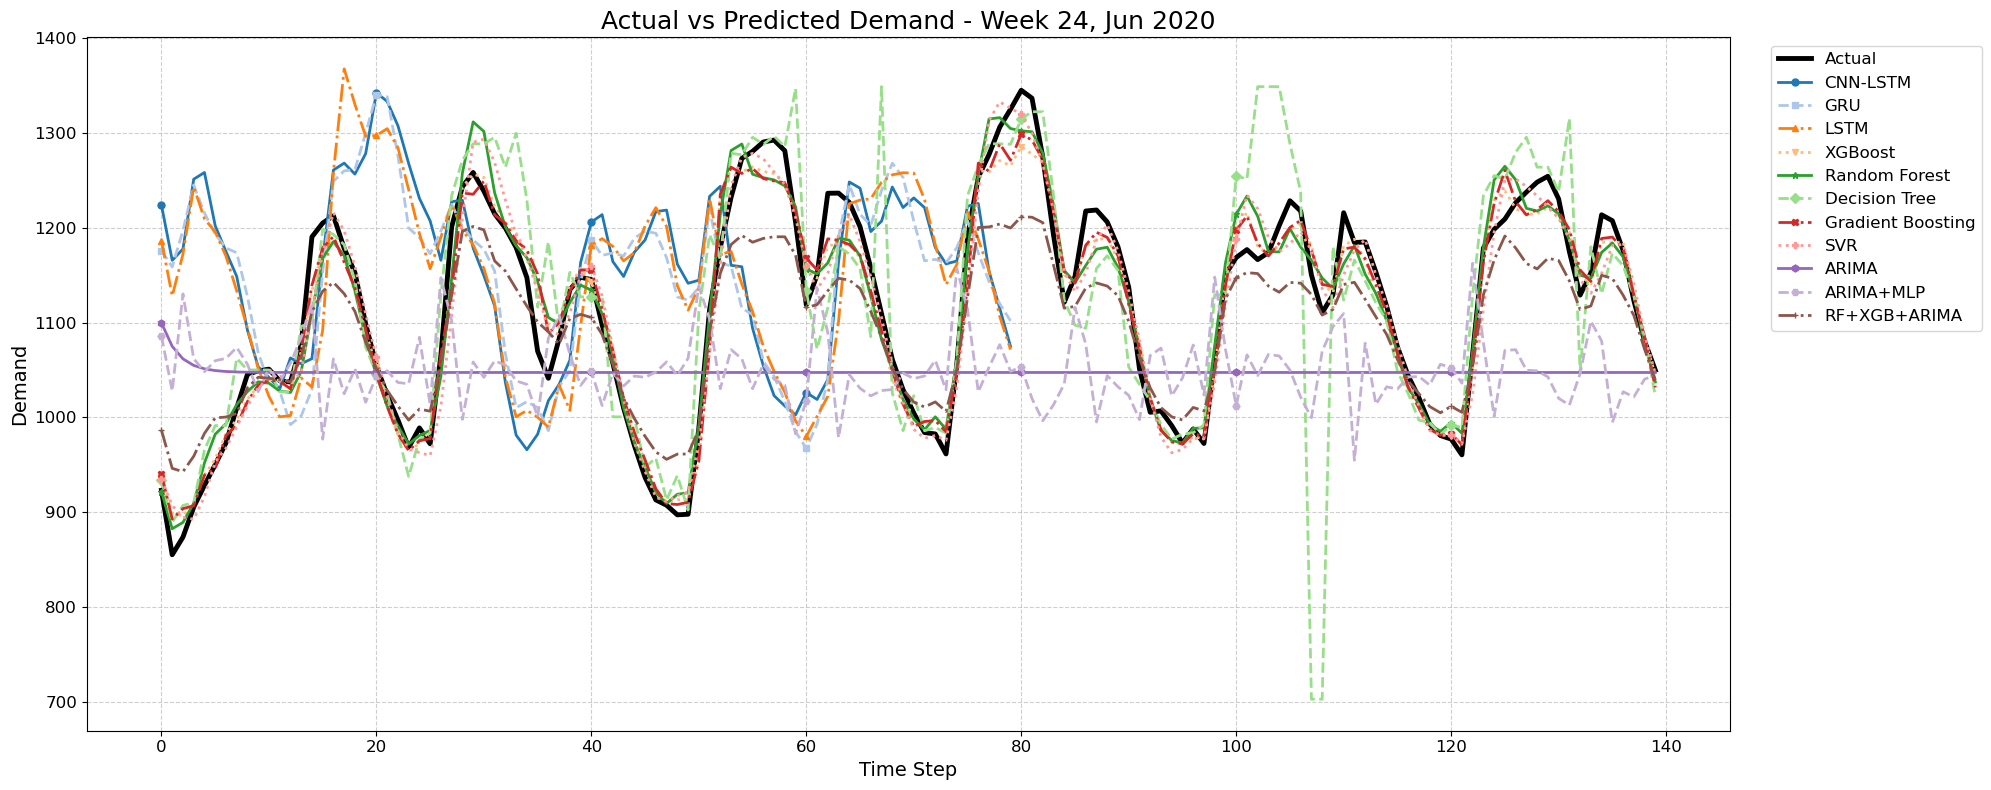

In [54]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.cm as cm

# ------------------- Utility Functions ------------------- #
def mean_percentage_absolute_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

def prepare_features(df):
    for lag in [1, 7, 14, 21, 28]:
        df[f"lag_{lag}"] = df["DEMAND"].shift(lag)
    for window in [3, 7, 14]:
        df[f"rolling_mean_{window}"] = df["DEMAND"].rolling(window=window).mean()
    df["rolling_std_7"] = df["DEMAND"].rolling(window=7).std()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)
    df.dropna(inplace=True)
    return df

# ------------------- Load Models ------------------- #
models_ml = {
    "XGBoost": joblib.load("./model_weights/tuned_xgb_model.pkl"),
    "Random Forest": joblib.load("./model_weights/tuned_random_forest_model.pkl"),
    "Decision Tree": joblib.load("./model_weights/tuned_decision_tree_model.pkl"),
    "Gradient Boosting": joblib.load("./model_weights/tuned_gradient_boosting_model.pkl"),
    "SVR": joblib.load("./model_weights/svr_rbf_model.pkl"),
}
cnn_lstm_model = load_model("./model_weights/cnn_lstm_model.h5")
gru_model = load_model("./model_weights/gru_model.h5")
lstm_model = load_model("./model_weights/lstm_model.h5")
arima_model = joblib.load("./model_weights/arima_model.pkl")
arima_mlp_arima = joblib.load("./model_weights/arima_mlp_hybrid_arima_part.pkl")
arima_mlp_mlp = joblib.load("./model_weights/arima_mlp_hybrid_mlp_part.pkl")
hybrid_rf = joblib.load("./model_weights/hybrid2_rf_model.pkl")
hybrid_xgb = joblib.load("./model_weights/hybrid2_xgb_model.pkl")
hybrid_arima = joblib.load("./model_weights/hybrid2_arima_model.pkl")

# ------------------- Iterate Through All Sheets ------------------- #
xls = pd.ExcelFile("./data/test_dataframes.xlsx")
sheet_names = xls.sheet_names
time_step = 60

for sheet in sheet_names:
    print(f"\n===== Processing Sheet: {sheet} =====")
    df = xls.parse(sheet)
    if "datetime" in df.columns:
        df["datetime"] = pd.to_datetime(df["datetime"])
        df.set_index("datetime", inplace=True)

    df = prepare_features(df)
    if len(df) < 100:  # Skip very small test cases
        print("Too few rows after feature prep, skipping...")
        continue

    X_test = df.drop(columns=["DEMAND"])
    y_test = df["DEMAND"]

    predictions_dict = {}

    # ----- DL Models ----- #
    scaler = MinMaxScaler()
    y_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))
    X_lstm, y_lstm = create_dataset(y_scaled, time_step)
    X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

    def evaluate_dl(model, name):
        pred = model.predict(X_lstm)
        pred_inv = scaler.inverse_transform(pred)
        predictions_dict[name] = pred_inv.flatten()

    evaluate_dl(cnn_lstm_model, "CNN-LSTM")
    evaluate_dl(gru_model, "GRU")
    evaluate_dl(lstm_model, "LSTM")

    # ----- ML Models ----- #
    for name, model in models_ml.items():
        pred = model.predict(X_test)
        predictions_dict[name] = pred.flatten()

    # ----- ARIMA ----- #
    arima_pred = arima_model.forecast(steps=len(X_test))
    predictions_dict["ARIMA"] = arima_pred.values

    # ----- ARIMA + MLP Hybrid ----- #
    arima_h = arima_mlp_arima.forecast(steps=len(X_test))
    mlp_residual = arima_mlp_mlp.predict(X_test)
    predictions_dict["ARIMA+MLP"] = (arima_h + mlp_residual).values

    # ----- RF + XGB + ARIMA Hybrid ----- #
    hybrid_pred = (
        hybrid_rf.predict(X_test) +
        hybrid_xgb.predict(X_test) +
        hybrid_arima.forecast(steps=len(X_test)).values
    ) / 3
    predictions_dict["RF+XGB+ARIMA"] = hybrid_pred

    # ------------------ Plot Actual vs Predicted ------------------ #
    plt.figure(figsize=(20, 8))
    start_idx = -300
    true_values = y_test.values[start_idx:]

    plt.plot(true_values, label="Actual", linewidth=3.5, color='black', linestyle='-')

    models_to_plot = list(predictions_dict.keys())
    colors = cm.tab20.colors
    linestyles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'v', '*', 'D', 'X', 'P', 'h', 'H', '+']

    for i, model in enumerate(models_to_plot):
        pred_vals = predictions_dict[model]
        aligned_pred = pred_vals[-len(true_values):]
        plt.plot(aligned_pred,
                 label=model,
                 linewidth=2,
                 color=colors[i % len(colors)],
                 linestyle=linestyles[i % len(linestyles)],
                 marker=markers[i % len(markers)],
                 markevery=20,
                 markersize=5)

    plt.title(f"Actual vs Predicted Demand - {sheet}", fontsize=18)
    plt.xlabel("Time Step", fontsize=14)
    plt.ylabel("Demand", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), fontsize=12)
    plt.tight_layout()
    plt.show()


Processing sheet: Week 15, Apr 2019


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 21, May 2019


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 24, Jun 2019


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 29, Jul 2019


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 33, Aug 2019


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 37, Sep 2019


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 41, Oct 2019


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 533ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 518ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 44, Nov 2019


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 51, Dec 2019


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 01, Jan 2020
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 656ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 836ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 06, Feb 2020


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 10, Mar 2020
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step  


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 20, May 2020
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

Processing sheet: Week 24, Jun 2020
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/2v/86sq867s35xc02tyt5c0rwh00000gp/T/ipykernel_1576/2309856203.py:18: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_pred

             Model         MAE        RMSE      MAPE
4    Random Forest    0.644046    0.959173  0.052094
5    Decision Tree    0.306167    1.259790  0.024536
15   Random Forest    1.302743    1.648897  0.102151
16   Decision Tree    1.324621    3.121929  0.100430
26   Random Forest    2.953272    3.873815  0.214328
..             ...         ...         ...       ...
130      ARIMA+MLP  261.116503  326.007269       NaN
118          ARIMA  275.159943  331.981840       NaN
119      ARIMA+MLP  275.149686  336.181316       NaN
30           ARIMA  313.575246  367.035839       NaN
31       ARIMA+MLP  313.997143  372.132658       NaN

[154 rows x 4 columns]


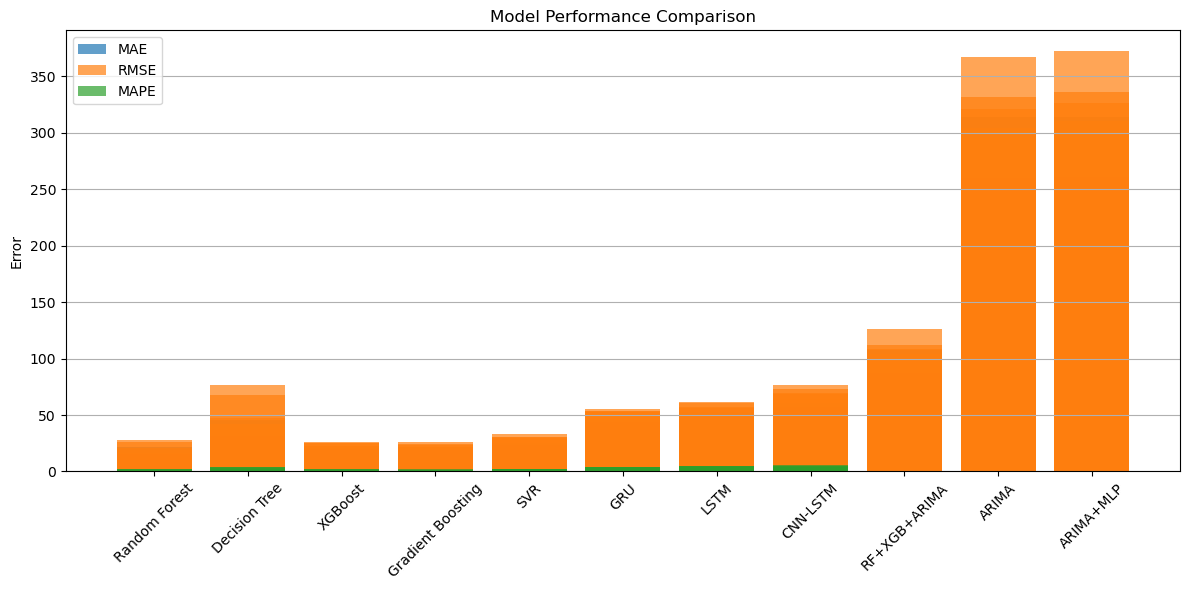

Average Errors across all sheets: {'MAE': 707.1160781187031, 'RMSE': 885.2088359710015, 'MAPE': nan}


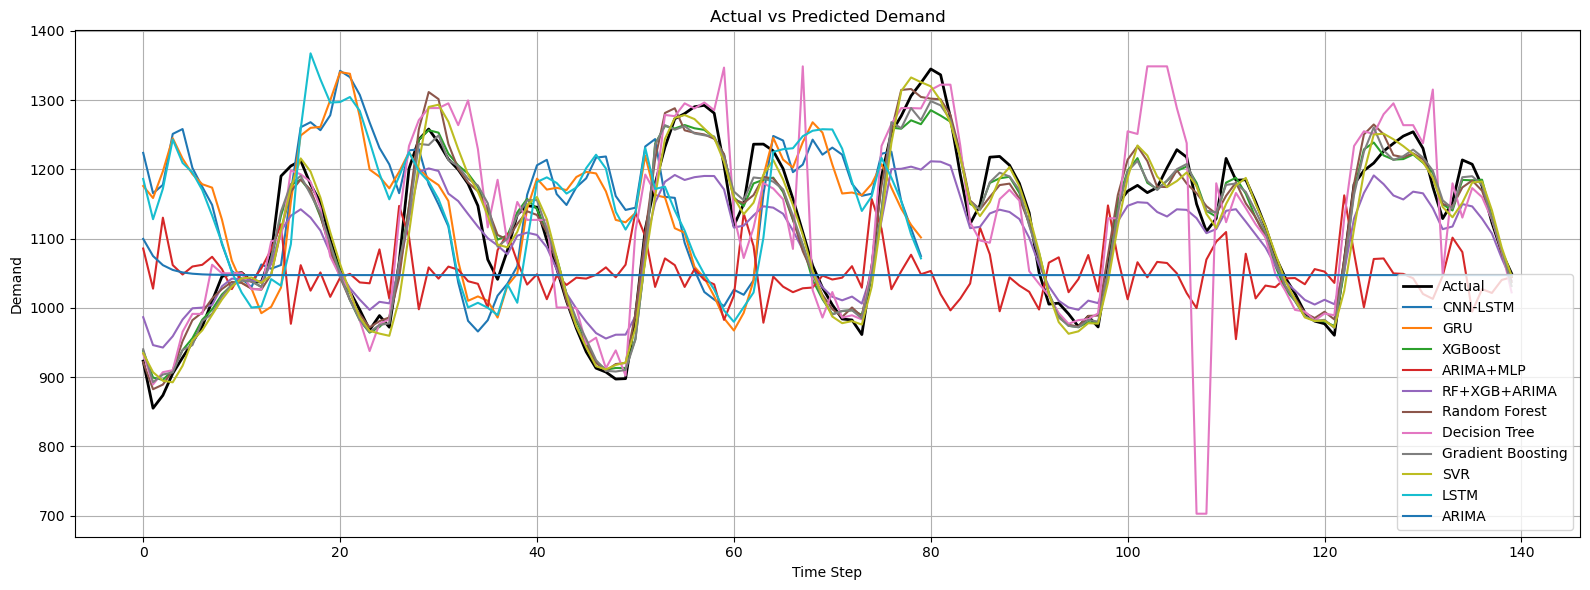

In [60]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load test dataset
test_df = pd.read_excel("./data/test_dataframes.xlsx", sheet_name=None)

# Initialize list to store results and dictionary to store predictions
results = []
predictions_dict = {}

# Define function for calculating MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to evaluate Deep Learning models
def evaluate_dl_model(model_path, name, X_test_lstm, y_test_lstm, scaler):
    model = load_model(model_path)
    pred = model.predict(X_test_lstm)
    pred_inv = scaler.inverse_transform(pred)
    y_inv = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
    
    mae = mean_absolute_error(y_inv, pred_inv)
    rmse = np.sqrt(mean_squared_error(y_inv, pred_inv))
    mape = calculate_mape(y_inv, pred_inv)
    
    results.append((name, mae, rmse, mape))
    predictions_dict[name] = pred_inv.flatten()

# Function to evaluate Machine Learning models
def evaluate_ml_model(model, name, X_test, y_test):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mape = calculate_mape(y_test, pred)
    
    results.append((name, mae, rmse, mape))
    predictions_dict[name] = pred.flatten()

# Process each sheet in the Excel file
for sheet_name, test_data in test_df.items():
    print(f"Processing sheet: {sheet_name}")

    # Parse datetime and set index
    if "datetime" in test_data.columns:
        test_data["datetime"] = pd.to_datetime(test_data["datetime"])
        test_data.set_index("datetime", inplace=True)

    # Feature engineering
    for lag in [1, 7, 14, 21, 28]:
        test_data[f"lag_{lag}"] = test_data["DEMAND"].shift(lag)
    for window in [3, 7, 14]:
        test_data[f"rolling_mean_{window}"] = test_data["DEMAND"].rolling(window=window).mean()
    test_data["rolling_std_7"] = test_data["DEMAND"].rolling(window=7).std()
    test_data["hour"] = test_data.index.hour
    test_data["dayofweek"] = test_data.index.dayofweek
    test_data["month"] = test_data.index.month
    test_data["is_weekend"] = test_data.index.dayofweek.isin([5, 6]).astype(int)

    test_data.dropna(inplace=True)

    # Define features and targets
    TARGET = "DEMAND"
    features = [col for col in test_data.columns if col != TARGET]
    X_test = test_data[features]
    y_test = test_data[TARGET]

    # Prepare data for CNN-LSTM / GRU / LSTM models
    def create_dataset(data, time_step=1):
        X, y = [], []
        for i in range(len(data) - time_step):
            X.append(data[i:(i + time_step), 0])
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)

    scaler = MinMaxScaler()
    y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))
    time_step = 60
    X_test_lstm, y_test_lstm = create_dataset(y_test_scaled, time_step)
    X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

    # Evaluate Deep Learning Models
    evaluate_dl_model("./model_weights/cnn_lstm_model.h5", "CNN-LSTM", X_test_lstm, y_test_lstm, scaler)
    evaluate_dl_model("./model_weights/gru_model.h5", "GRU", X_test_lstm, y_test_lstm, scaler)
    evaluate_dl_model("./model_weights/lstm_model.h5", "LSTM", X_test_lstm, y_test_lstm, scaler)

    # Evaluate Machine Learning Models
    models_ml = {
        "XGBoost": joblib.load("./model_weights/tuned_xgb_model.pkl"),
        "Random Forest": joblib.load("./model_weights/tuned_random_forest_model.pkl"),
        "Decision Tree": joblib.load("./model_weights/tuned_decision_tree_model.pkl"),
        "Gradient Boosting": joblib.load("./model_weights/tuned_gradient_boosting_model.pkl"),
        "SVR": joblib.load("./model_weights/svr_rbf_model.pkl"),
    }

    for name, model in models_ml.items():
        evaluate_ml_model(model, name, X_test, y_test)

    # ARIMA
    arima = joblib.load("./model_weights/arima_model.pkl")
    arima_pred = arima.forecast(steps=len(X_test))
    mae = mean_absolute_error(y_test, arima_pred)
    rmse = np.sqrt(mean_squared_error(y_test, arima_pred))
    mape = calculate_mape(y_test, arima_pred)
    results.append(("ARIMA", mae, rmse, mape))
    predictions_dict["ARIMA"] = arima_pred.values

    # ARIMA-MLP Hybrid
    arima_h, mlp_h = joblib.load("./model_weights/arima_mlp_hybrid_arima_part.pkl"), joblib.load("./model_weights/arima_mlp_hybrid_mlp_part.pkl")
    arima_pred = arima_h.forecast(steps=len(X_test))
    mlp_residual = mlp_h.predict(X_test)
    hybrid_pred = arima_pred + mlp_residual
    mae = mean_absolute_error(y_test, hybrid_pred)
    rmse = np.sqrt(mean_squared_error(y_test, hybrid_pred))
    mape = calculate_mape(y_test, hybrid_pred)
    results.append(("ARIMA+MLP", mae, rmse, mape))
    predictions_dict["ARIMA+MLP"] = hybrid_pred.values

    # RF+XGB+ARIMA Hybrid
    rf_h, xgb_h, arima_h = joblib.load("./model_weights/hybrid2_rf_model.pkl"), joblib.load("./model_weights/hybrid2_xgb_model.pkl"), joblib.load("./model_weights/hybrid2_arima_model.pkl")
    hybrid2_pred = (rf_h.predict(X_test) + xgb_h.predict(X_test) + arima_h.forecast(steps=len(X_test))) / 3
    mae = mean_absolute_error(y_test, hybrid2_pred)
    rmse = np.sqrt(mean_squared_error(y_test, hybrid2_pred))
    mape = calculate_mape(y_test, hybrid2_pred)
    results.append(("RF+XGB+ARIMA", mae, rmse, mape))
    predictions_dict["RF+XGB+ARIMA"] = hybrid2_pred.values

# ------------------ Plot Errors ------------------ #
df_results = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "MAPE"]).sort_values(by="RMSE")
print(df_results)

plt.figure(figsize=(12, 6))
plt.bar(df_results["Model"], df_results["MAE"], alpha=0.7, label="MAE")
plt.bar(df_results["Model"], df_results["RMSE"], alpha=0.7, label="RMSE")
plt.bar(df_results["Model"], df_results["MAPE"], alpha=0.7, label="MAPE")
plt.title("Model Performance Comparison")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis="y")
plt.show()

# ------------------ Collect and Compute Average Errors ------------------ #
avg_errors = {"MAE": 0, "RMSE": 0, "MAPE": 0}
num_sheets = len(test_df)

# Calculate the average errors
for model_name, mae, rmse, mape in results:
    avg_errors["MAE"] += mae
    avg_errors["RMSE"] += rmse
    avg_errors["MAPE"] += mape

avg_errors["MAE"] /= num_sheets
avg_errors["RMSE"] /= num_sheets
avg_errors["MAPE"] /= num_sheets

# Print the average errors across all sheets
print(f"Average Errors across all sheets: {avg_errors}")

# ------------------ Plot Actual vs Predicted ------------------ #
# Choose a few models to visualize
selected_models = ["CNN-LSTM", "GRU", "XGBoost", "ARIMA+MLP", "RF+XGB+ARIMA", "Random Forest", "Decision Tree", "Gradient Boosting", "SVR", "LSTM", "ARIMA"]

plt.figure(figsize=(16, 6))
start_idx = -300  # Adjust to control how many points to show
true_values = test_data[TARGET].values[start_idx:]
plt.plot(true_values, label="Actual", linewidth=2, color='black')

for model in selected_models:
    pred_vals = predictions_dict[model]
    aligned_pred = pred_vals[-len(true_values):]
    plt.plot(aligned_pred, label=model)

plt.title("Actual vs Predicted Demand")
plt.xlabel("Time Step")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
